In [203]:
import pandas as pd
import plotnine as pn
import numpy as np

from tqdm import tqdm

In [204]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

density  edginess  references  citations_per_year  is_center  \
0       1545.550332  0.814415          42            2.250000      False   
1       1846.261870  0.452021          88            4.625000      False   
2       1703.520959  0.490212          30            0.882353      False   
3       1901.386693  0.715160          95            8.166667      False   
4        535.472125  0.885892          94            2.090909      False   
...             ...       ...         ...                 ...        ...   
529397    48.730838  0.658585          41            3.500000      False   
529398    25.107589  0.721374          38            3.200000      False   
529399    41.647954  0.646499          11            1.529412      False   
529400    35.738649  0.708053          15            2.384615      False   
529401    31.749805  0.670620           7            0.000000      False   

                                      identifier  year librarian vectorizer  \
0       2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f  2004        S2       GPT2   
1       d7b6cd39dd111afa55a3aa418b7b5459db12988d  2012        S2       GPT2   
2       2d62ec65f95435c72ef750b3cff331382c5dca92  2003        S2       GPT2   
3       8cebc6e3dcfb543bad48d89112e281a6e11c33c2  2014        S2       GPT2   
4       59730a4bae4dc53f59341b63fd1e63451c589e9f  2009        S2       GPT2   
...                                          ...   ...       ...        ...   
529397  806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24  2018        S2    SciBERT   
529398  f40707d1165c22e185c25e6837977177ee380f2c  2015        S2    SciBERT   
529399  10636ee16779a7521001651164acb5c192d4ad7b  2003        S2    SciBERT   
529400  a229f829e0a5362d00e63781f687f40ede991635  2007        S2    SciBERT   
529401  8f7f47c0acd81752039abad380df57cf39591506  2012        S2    SciBERT   

                                center fields_of_study_0  
0       hafenLowredshiftLymanLimit2017           Physics  
1       hafenLowredshiftLymanLimit2017           Physics  
2       hafenLowredshiftLymanLimit2017           Physics  
3       hafenLowredshiftLymanLimit2017           Physics  
4       hafenLowredshiftLymanLimit2017           Physics  
...                                ...               ...  
529397                       Andre2018       Mathematics  
529398                       Andre2018       Mathematics  
529399                       Andre2018       Mathematics  
529400                       Andre2018       Mathematics  
529401                       Andre2018       Mathematics  

[529402 rows x 11 columns]

In [205]:
# df_all = df_all[df_all["year"] == 2018]
vectorizer = "SBERT"
df_all = df_all[df_all["vectorizer"] == vectorizer]
# df_all = df_all[df_all["vectorizer"] == "Word2Vec"]

In [206]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [207]:
# df = df_all[df_all["citations_per_year"] > 0]
# df = df_all[df_all["density"] < 100] # hacky
df = df_all
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/81577959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/81577959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [208]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 20) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    data_bins = df[["log_cpy", "density_bin", "citations_per_year", "references", "year"]]

    log_ents = [
        entropy_estimator(
            observations=data_bins[data_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # forget about entropy, we have a continuous variable so look at variance instead
    log_variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    
    # and median
    log_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    means = [
            np.nanmean(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    ref_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["references"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    
    ref_variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["references"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    year_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]


    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(
            bins, 
            df.density_bin.value_counts(sort=False, normalize=True), 
            df.density_bin.value_counts(sort=False, normalize=False),
            log_ents, 
            log_variances,
            log_medians,
            variances,
            medians,
            means,
            ref_medians,
            ref_variances,
            year_medians,
            ),
        columns=[
            "density_bin", 
            "freq", 
            "count", 
            "log_cpy entropy", 
            "log_cpy variance",
            "log_cpy median",
            "cpy_var",
            "cpy_med",
            "cpy_mean",
            "ref_med",
            "ref_var",
            "year_med",
        ],
    )
    df_ent["field"] = field

    return df_ent


In [209]:
# Zach's algo

def get_df_var(df_in: pd.DataFrame, field: str, num_bins = 100, n_bin = 100) -> pd.DataFrame:
    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # TODO: can we annotate the percentiles for these bins?
    

    # n_bin = 200 # play with this
    # sample_size = 200

    d_bins = df.density_bin.unique()
    data = []

    for d_bin in d_bins:
        df_bin: pd.DataFrame = df[df["density_bin"] == d_bin]
        n_in_density_bin = len(df_bin)
        n_steps = int(n_in_density_bin / n_bin)
        data_sorted_by_cpy = df_bin.sample(frac=1)
        

        for step in range(0, n_steps, n_bin):
            # data_sorted_by_cpy = df_bin.sort_values("citations_per_year")
            # if sample_size > len(df_bin):
                # raise Exception
            # data_sorted_by_cpy = df_bin.sample(frac=1)
            # print("ALL OBSERVATIONS: ", data_sorted_by_cpy)
            if n_bin > len(df_bin):
                raise Exception
            data_to_bin = df_bin.sample(n_bin)
            # data_to_bin = data_sorted_by_cpy[step: step + n_bin]

            var_cpy_in_density_bin = np.nanvar(data_to_bin["citations_per_year"])
            var_log_cpy_in_density_bin = np.nanvar(data_to_bin["log_cpy"])

            median_density_in_density_bin = np.nanmedian(data_to_bin["density"])
            median_cpy_in_density_bin = np.nanmedian(data_to_bin["citations_per_year"])
            mean_cpy_in_density_bin = np.nanmean(data_to_bin["citations_per_year"])
            median_log_cpy_in_density_bin = np.nanmedian(data_to_bin["log_cpy"])

            data.append(
                (
                    median_density_in_density_bin, 
                    median_cpy_in_density_bin,
                    mean_cpy_in_density_bin,
                    median_log_cpy_in_density_bin,
                    var_cpy_in_density_bin,
                    var_log_cpy_in_density_bin,
                    field,
                )
            )
    
    return pd.DataFrame(
        data,
        columns=[
            "density_med_bin", 
            "cpy_med_bin", 
            "cpy_mean_bin",
            "log_cpy_med_bin",
            "cpy_var",
            "log_cpy_var", 
            "field",
        ],
    )


get_df_var(df, "Physics", n_bin=10)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_med_bin  cpy_med_bin  cpy_mean_bin  log_cpy_med_bin      cpy_var  \
0          22.697476    11.176471     12.709262         1.048251   117.464194   
1          22.699351    10.544444      9.623451         1.022792    48.987642   
2          22.694696    11.090909     11.929134         1.044953    65.246477   
3          22.663559     6.850000     28.404848         0.875061  3906.013403   
4          20.468571    11.289474     12.565074         1.047631    99.976122   
..               ...          ...           ...              ...          ...   
147        25.954853     7.816667     12.234167         0.893021   255.319062   
148        26.557096     8.000000     33.485606         0.937852  5299.117016   
149        26.736008     7.000000     23.266071         0.834891  1064.267106   
150        26.354669     7.333333      7.098333         0.903090    14.360914   
151        27.042945    12.500000     35.323810         1.096562  3333.200816   

     log_cpy_var    field  
0       0.228349  Physics  
1       0.382382  Physics  
2       0.102426  Physics  
3       0.233449  Physics  
4       0.771839  Physics  
..           ...      ...  
147     0.149540  Physics  
148     0.313382  Physics  
149     0.266368  Physics  
150     0.041951  Physics  
151     0.430030  Physics  

[152 rows x 7 columns]

#### New scatterplot with trendlines

Why are the trends so robustly U-shaped?

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

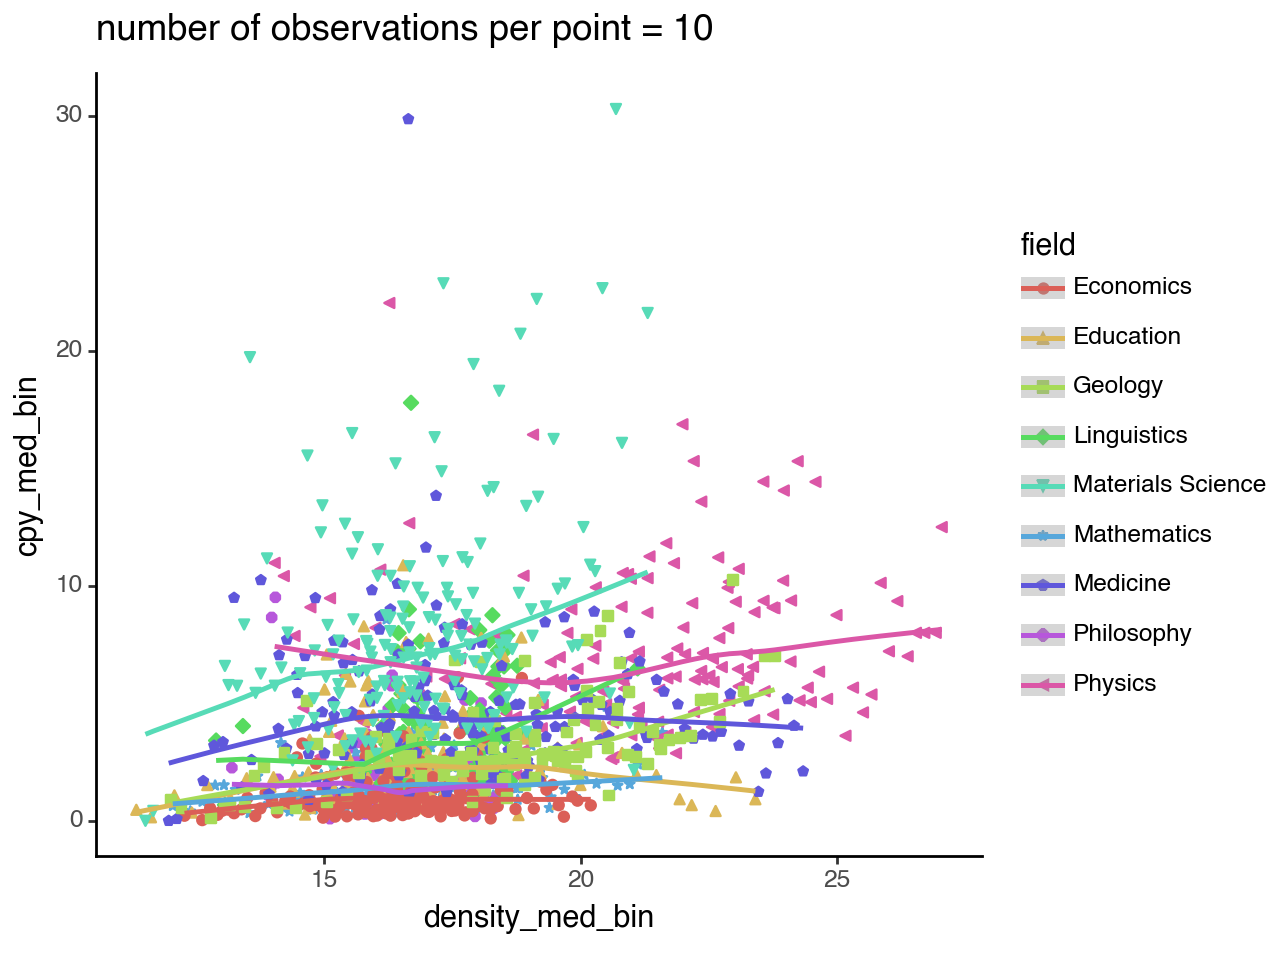

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

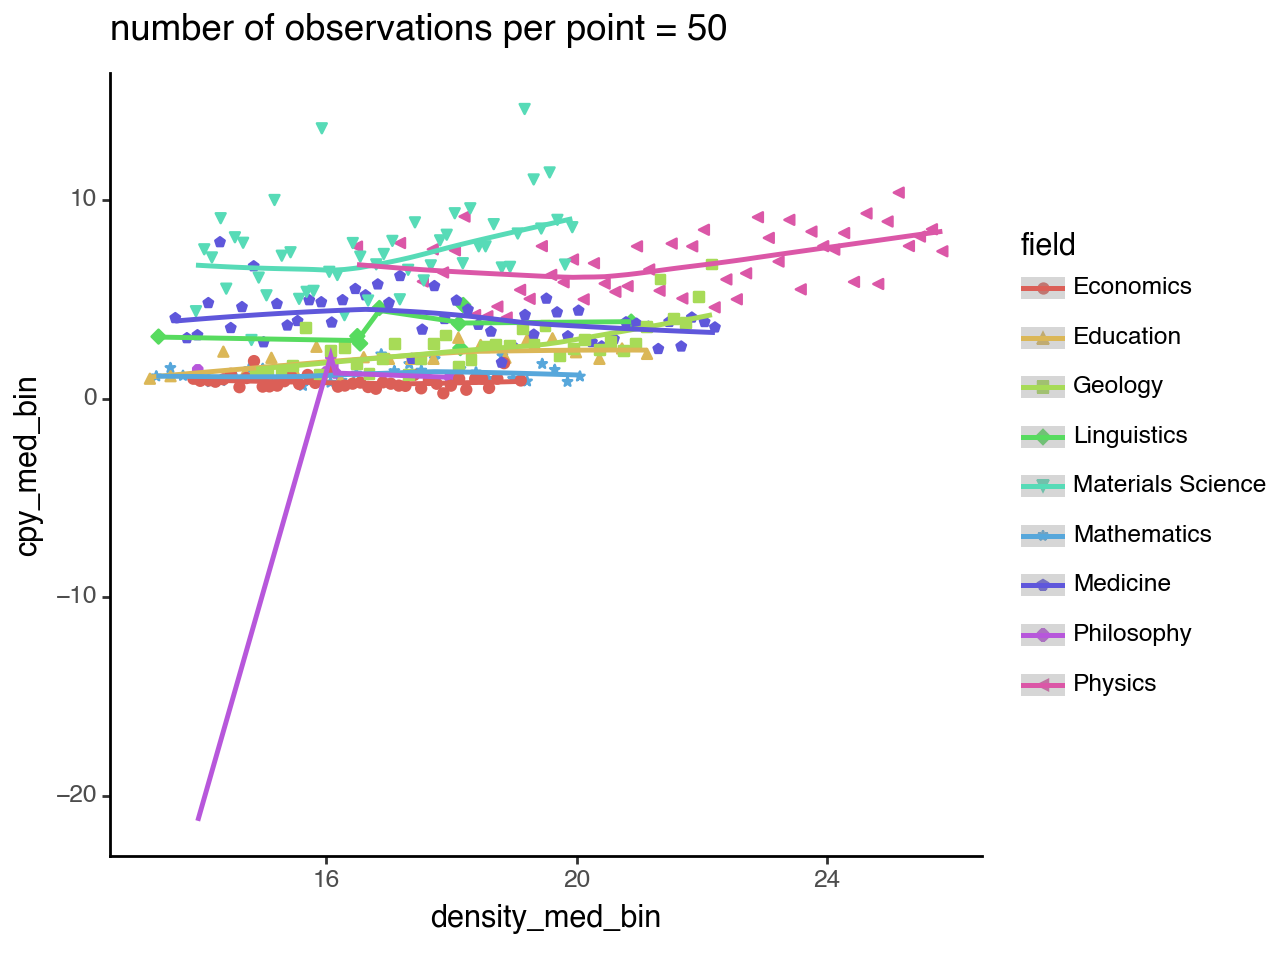

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

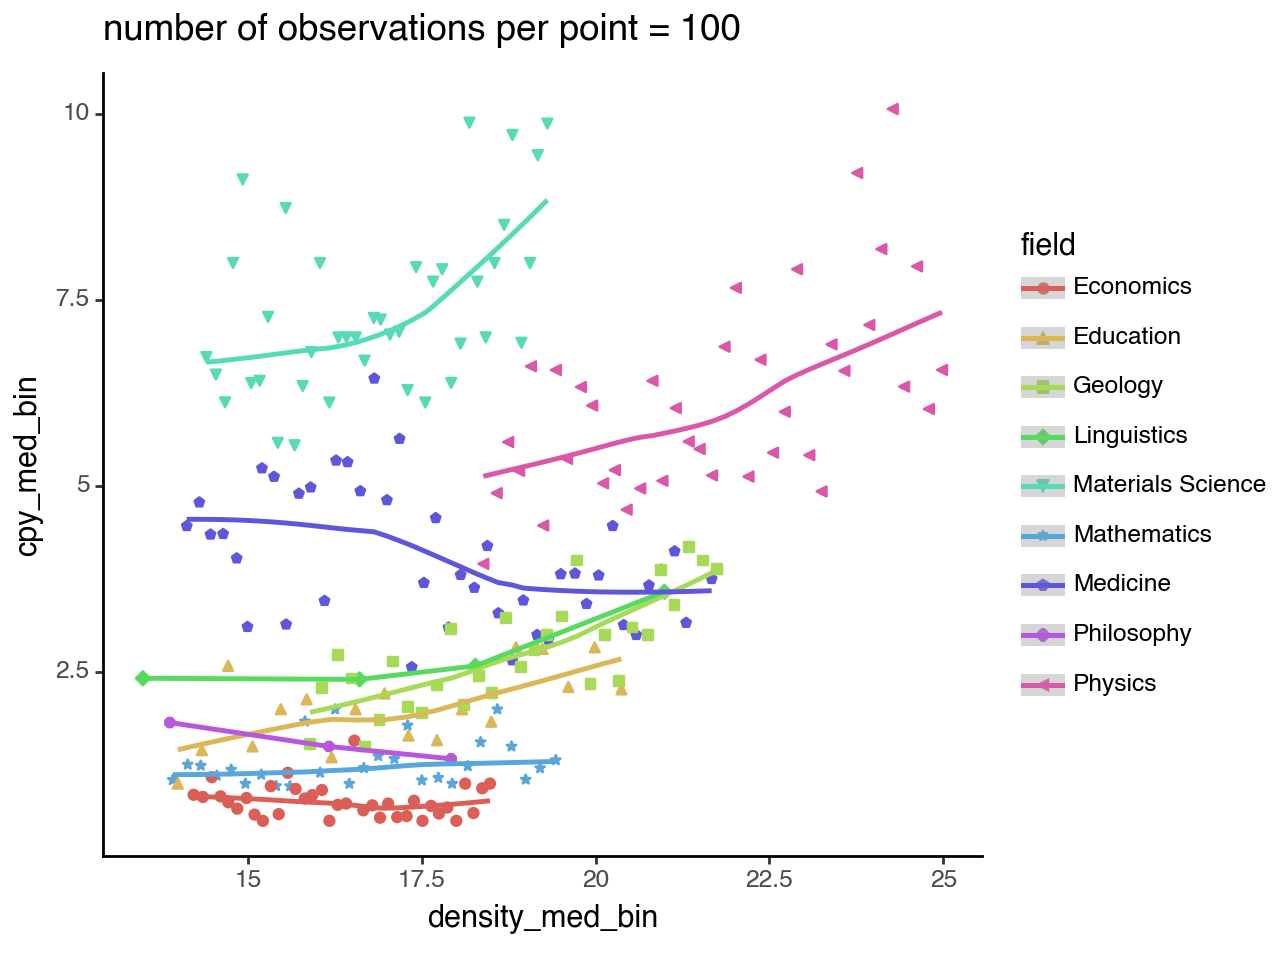

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

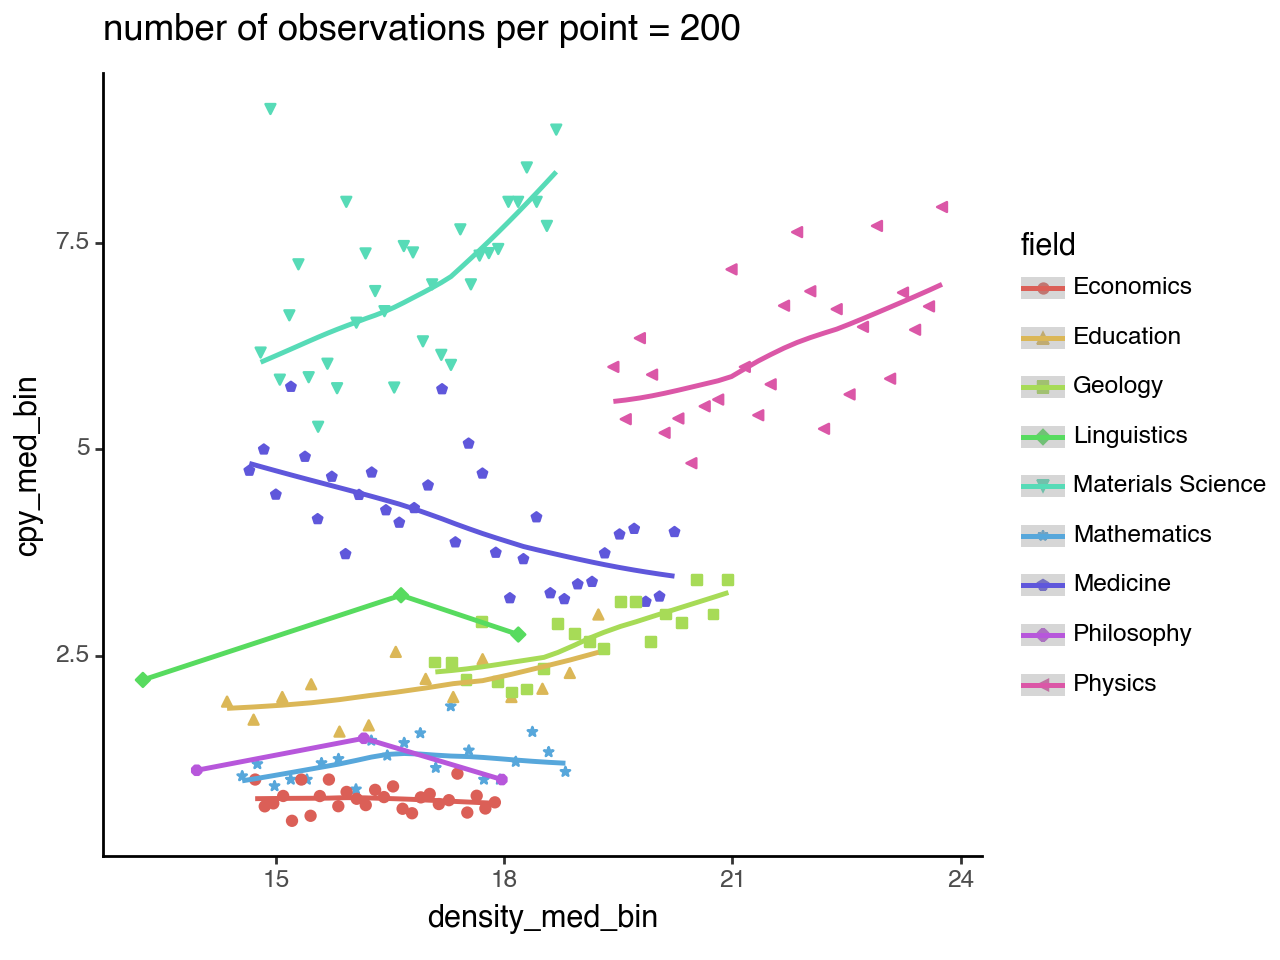

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

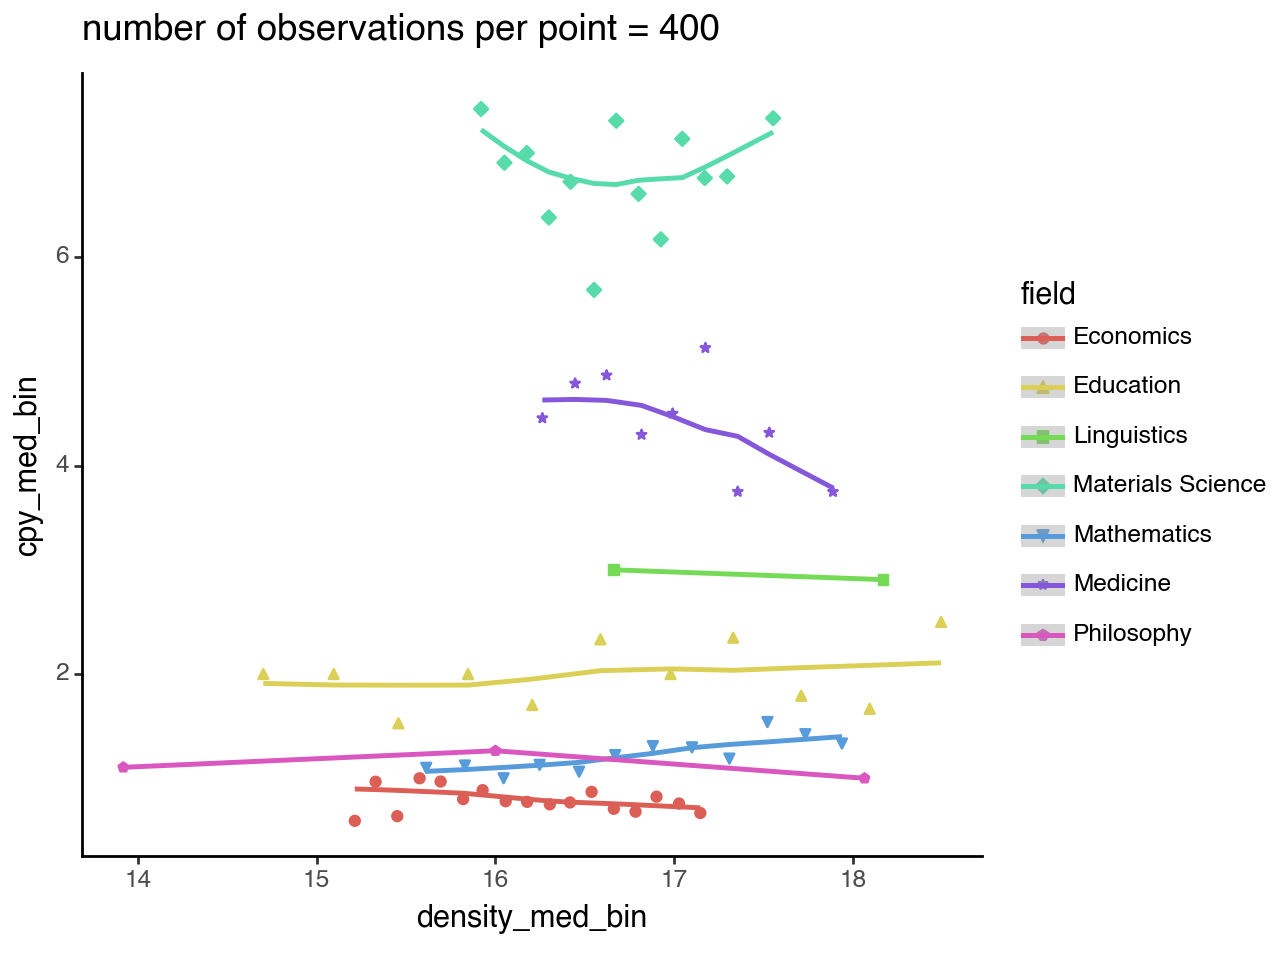

In [210]:
for n_bin in [10, 50, 100, 200, 400]:

    print(
        pn.ggplot(
            pd.concat(
            [get_df_var(df, field, n_bin=n_bin)
            for field in df["fields_of_study_0"].unique()],
            ),
            pn.aes(
                x="density_med_bin",
                # y="log_cpy_med_bin",
                # y="log_cpy_var",
                y="cpy_med_bin",
                # y="cpy_var",
                # color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                shape="field",
                color="field",
            ),
            # color="black",
            # alpha=0.1,
        )
        + pn.geom_smooth(
            pn.aes(
                color="field",
            )
        )
        # + pn.ylab("Variance in citations per year")
        # + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
        # + pn.ylim(0,2)
        + pn.ggtitle(f"number of observations per point = {n_bin}")
    )

In [211]:
pd.concat(
    [get_df_var(df, field, n_bin=100)
    for field in df["fields_of_study_0"].unique()],
).to_csv("dmb_vs_log_cpy_var.csv", index=False)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [212]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        11.015  0.001326     15              NaN          0.445779   
1        11.882  0.003006     34              NaN          0.589838   
2        12.749  0.002652     30              NaN          0.594991   
3        13.616  0.003713     42              NaN          0.490082   
4        14.482  0.007779     88              NaN          0.428750   
5        15.349  0.012288    139              NaN          0.492265   
6        16.216  0.019537    221              NaN          0.407540   
7        17.083  0.028200    319              NaN          0.340597   
8        17.949  0.050301    569              NaN          0.371329   
9        18.816  0.078589    889              NaN          0.302740   
10       19.683  0.116160   1314              NaN          0.277111   
11       20.550  0.148957   1685              NaN          0.244198   
12       21.416  0.157620   1783              NaN          0.252042   
13       22.283  0.149929   1696              NaN          0.247444   
14       23.150  0.107850   1220              NaN          0.250608   
15       24.017  0.058699    664              NaN          0.250970   
16       24.883  0.035626    403              NaN          0.211600   
17       25.750  0.012818    145              NaN          0.191854   
18       26.617  0.004332     49         7.202088          0.250780   
19       27.484  0.000619      7              NaN          0.116535   

    log_cpy median       cpy_var   cpy_med   cpy_mean  ref_med       ref_var  \
0         0.863898    976.651833  5.857143  15.191360     46.0   3247.422222   
1         0.437531   2290.345959  1.277778  14.295224     45.0   4337.633218   
2         0.753328  14370.822270  5.333333  31.796002     61.0  95765.845556   
3         0.970037  64361.900252  8.158824  52.176059     45.0   3804.916100   
4         0.801030   1840.244819  5.639319  16.291812     39.0   2835.158574   
5         0.845098   1712.167361  6.428571  20.808611     30.0  13466.518503   
6         0.873447   5450.180904  6.384615  22.027908     41.0  12199.370529   
7         0.823909   1526.748035  6.500000  15.292282     49.0   3466.222895   
8         0.751725   7323.564637  5.250000  20.266662     48.0   4979.835731   
9         0.736360    881.271670  5.230769  12.703634     58.0   2972.517769   
10        0.755288    477.819942  5.529825  11.221791     60.0   2002.157132   
11        0.784736    217.573325  6.000000  10.214380     65.0   3018.575120   
12        0.829304    361.562817  6.555556  11.180977     69.0   2157.916126   
13        0.827000    328.212648  6.500000  11.501931     73.0   2288.574425   
14        0.845098    635.936936  6.666667  12.818855     76.0   2515.621104   
15        0.893947    285.724213  7.666667  12.816140     81.0   1914.249399   
16        0.922549    228.987173  8.000000  12.739709     81.0   2011.406154   
17        0.888351    585.810697  7.428571  13.445254     88.0   2440.842806   
18        0.929419   1076.544637  8.500000  19.380580     87.0   2193.804248   
19        0.941831     47.670907  6.750000   8.765306     82.0    674.489796   

    year_med    field  
0     2008.0  Physics  
1     2013.5  Physics  
2     2010.5  Physics  
3     2011.5  Physics  
4     2012.0  Physics  
5     2010.0  Physics  
6     2010.0  Physics  
7     2010.0  Physics  
8     2010.0  Physics  
9     2010.0  Physics  
10    2011.0  Physics  
11    2011.0  Physics  
12    2012.0  Physics  
13    2013.0  Physics  
14    2014.0  Physics  
15    2014.0  Physics  
16    2014.0  Physics  
17    2015.0  Physics  
18    2016.0  Physics  
19    2015.0  Physics

In [213]:
df_ent_all = pd.concat(
    [get_df_ent(df, field, num_bins=100)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/numpy/lib/nanfunc

density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        11.015  0.000265      3              NaN          0.057704   
1        11.189  0.000354      4        21.816720          0.175600   
2        11.362  0.000265      3              NaN          0.648557   
3        11.535  0.000177      2              NaN          0.000000   
4        11.709  0.000265      3       137.265501          0.038954   
..          ...       ...    ...              ...               ...   
95       31.660  0.000000      0              NaN               NaN   
96       31.873  0.000000      0              NaN               NaN   
97       32.086  0.000170      2        25.548561          0.469289   
98       32.298  0.000000      0              NaN               NaN   
99       32.511  0.000085      1              NaN          0.000000   

    log_cpy median      cpy_var    cpy_med   cpy_mean  ref_med      ref_var  \
0         1.007902    54.244113   5.857143   7.854342     39.0  2702.000000   
1         0.438007     6.347045   3.447802   3.487557     49.0   108.500000   
2         0.425119    62.686728   0.416667   5.805556    116.0  2264.000000   
3         2.110108  4151.040816  64.428571  64.428571     44.5     2.250000   
4         1.051153    49.492284  11.250000  14.694444     80.0  6994.666667   
..             ...          ...        ...        ...      ...          ...   
95             NaN          NaN        NaN        NaN      NaN          NaN   
96             NaN          NaN        NaN        NaN      NaN          NaN   
97        0.031835     6.220794   2.716374   2.716374     28.5     6.250000   
98             NaN          NaN        NaN        NaN      NaN          NaN   
99        0.489020     0.000000   3.083333   3.083333     17.0     0.000000   

    year_med        field  
0     2008.0      Physics  
1     2006.0      Physics  
2     2012.0      Physics  
3     2011.5      Physics  
4     2016.0      Physics  
..       ...          ...  
95       NaN  Mathematics  
96       NaN  Mathematics  
97    2001.5  Mathematics  
98       NaN  Mathematics  
99    2008.0  Mathematics  

[900 rows x 13 columns]

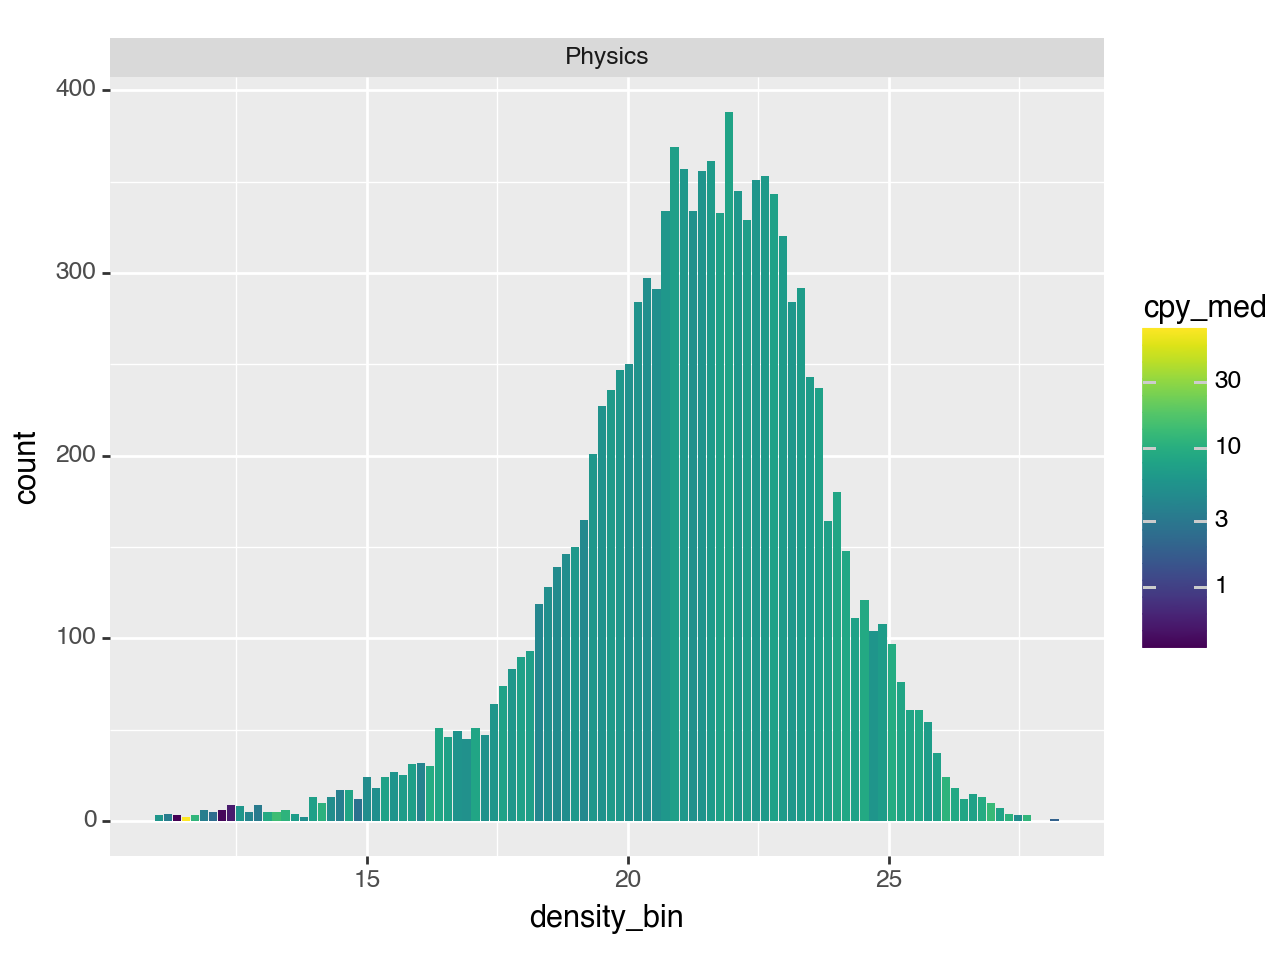

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


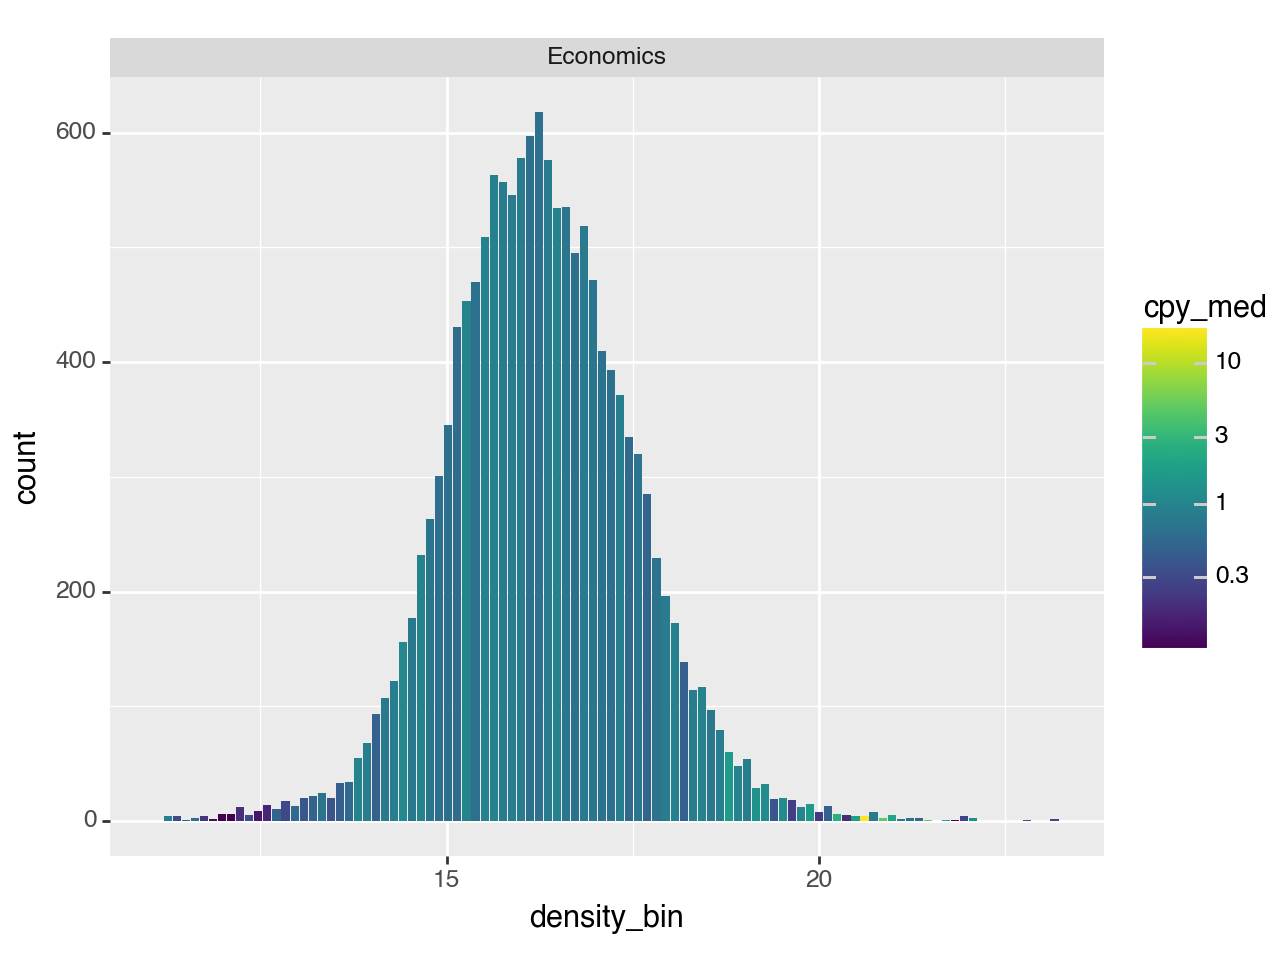

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


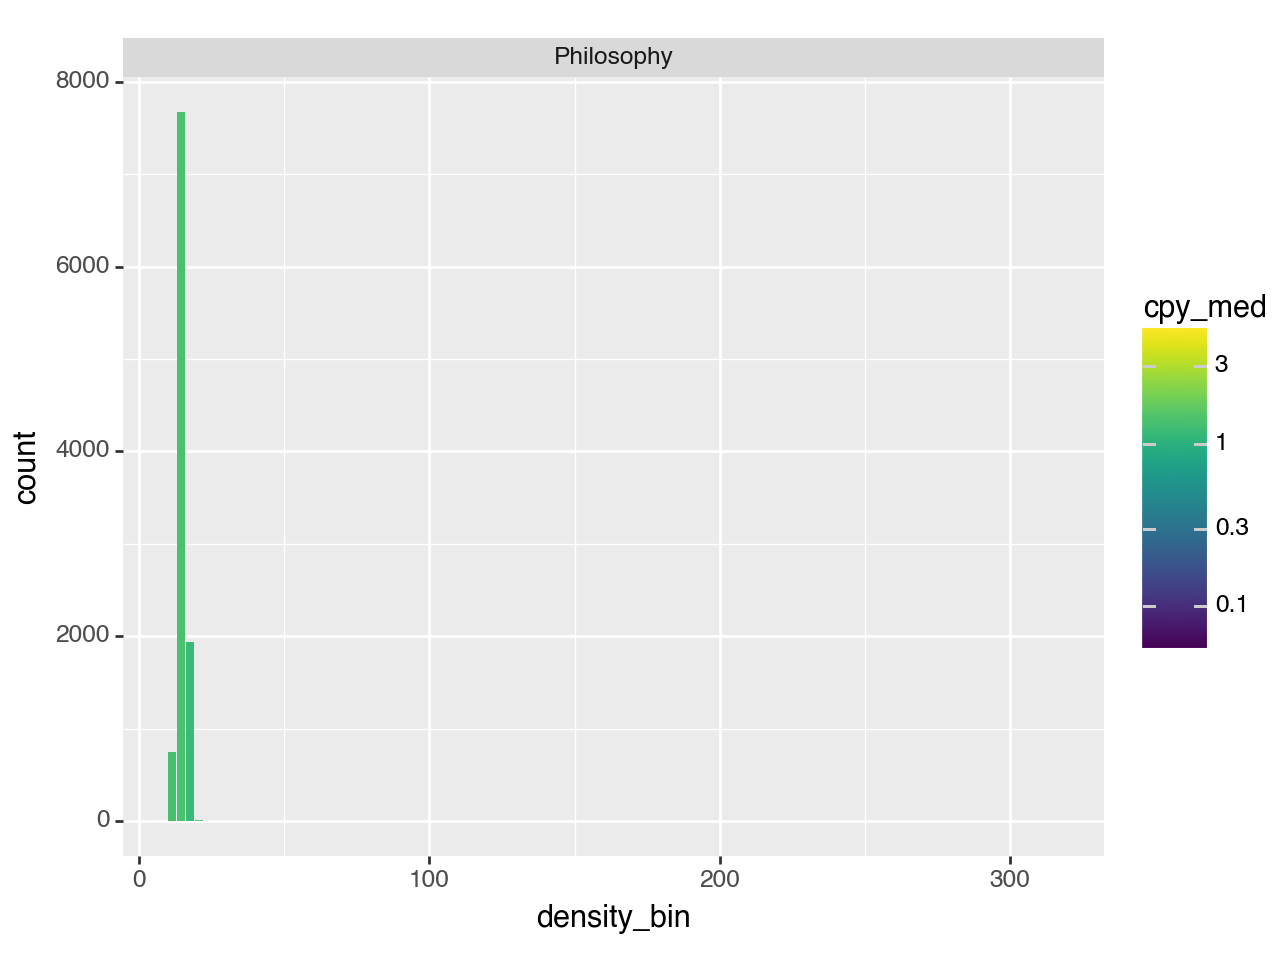

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


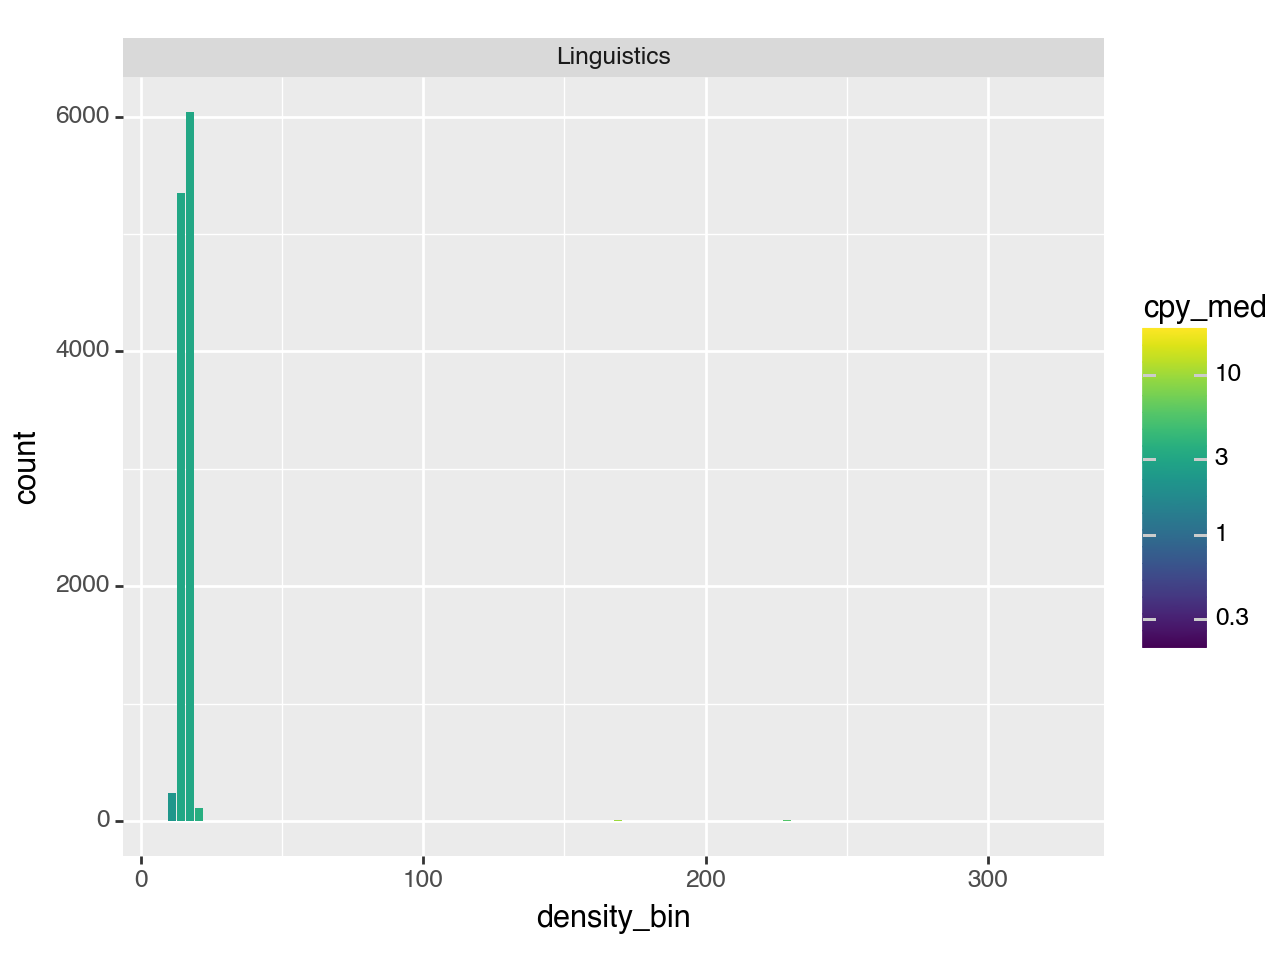

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


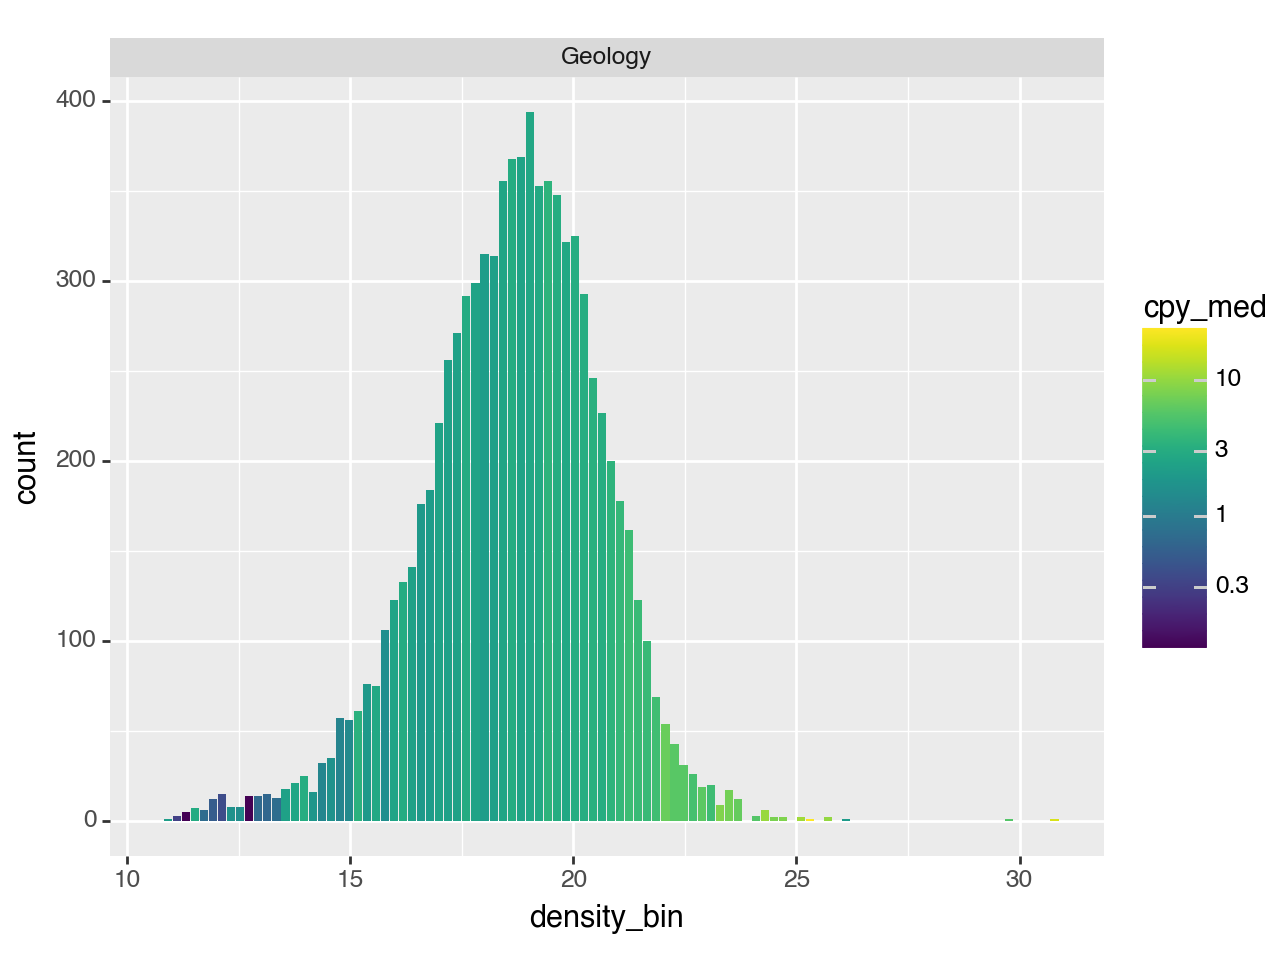

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


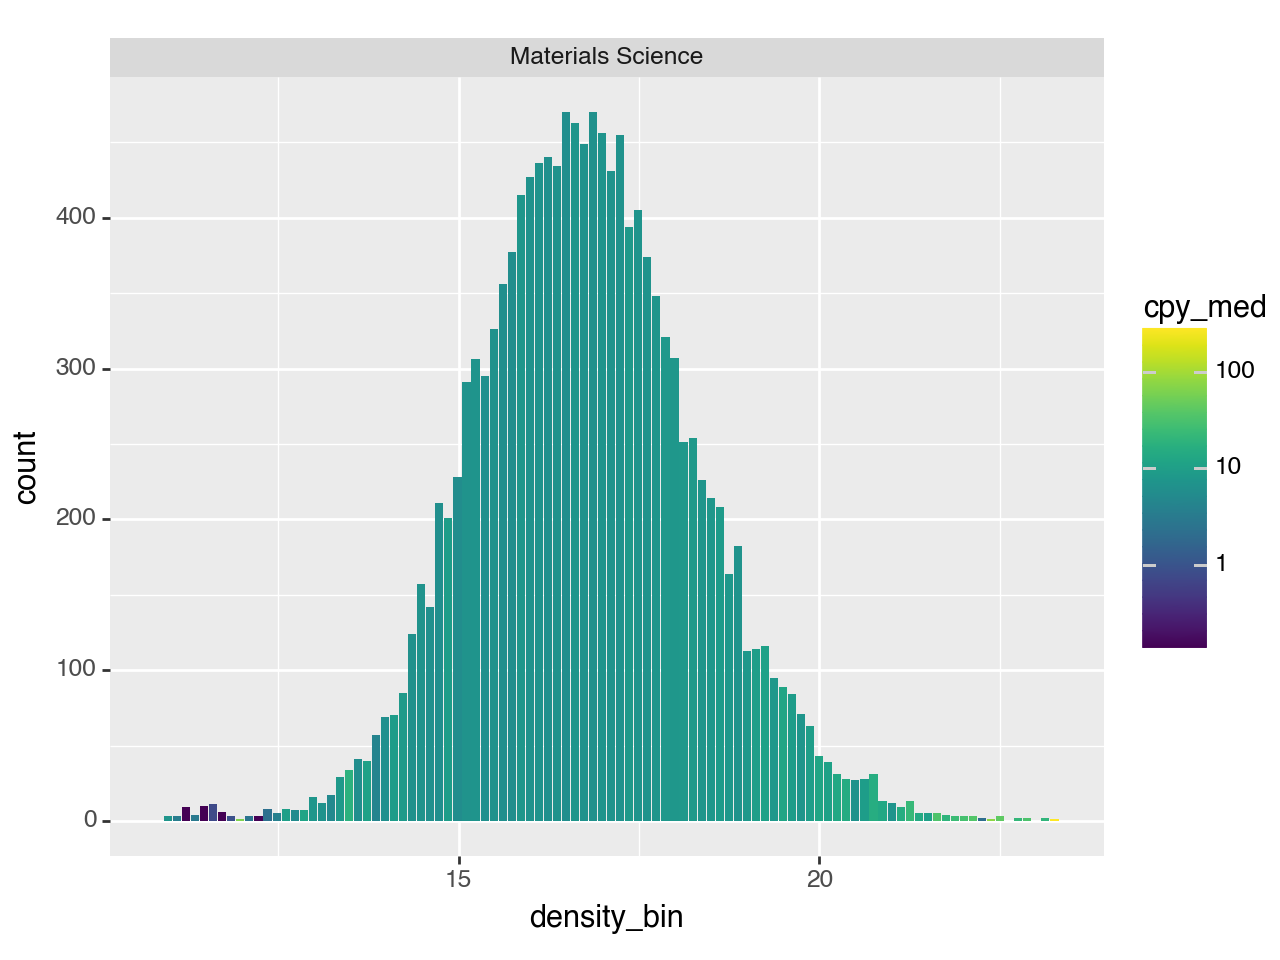

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


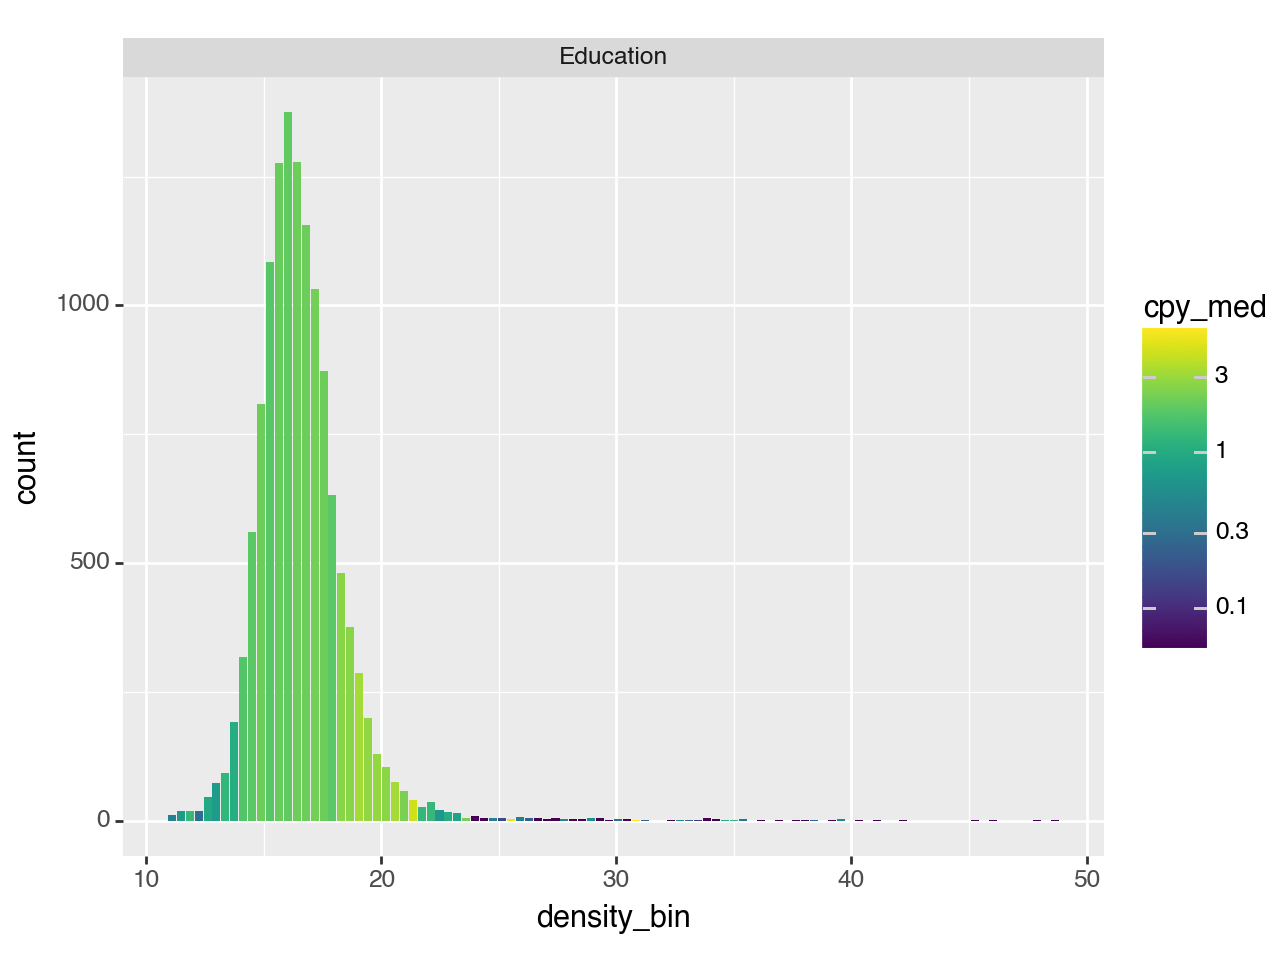

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


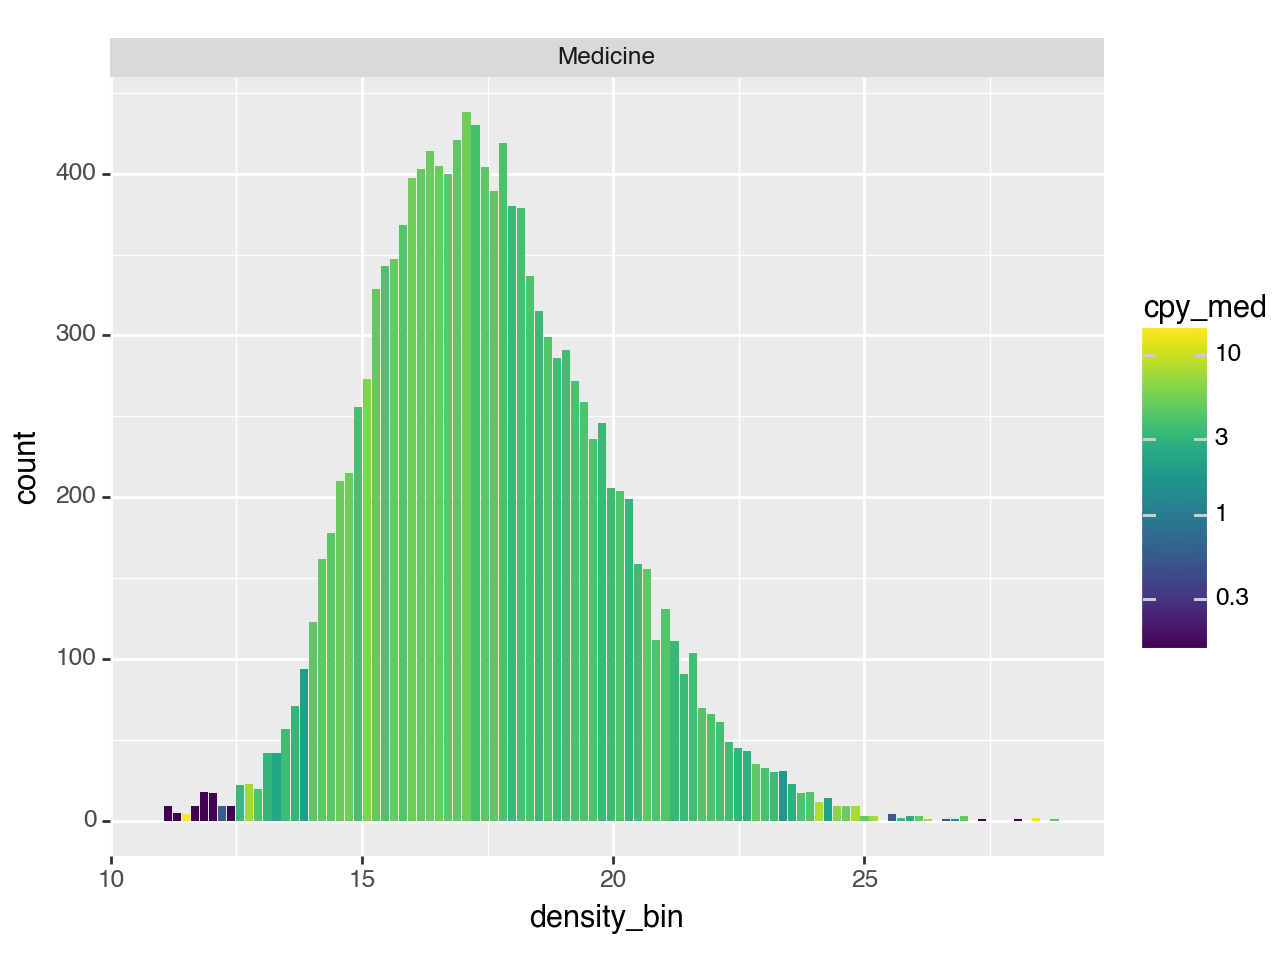

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


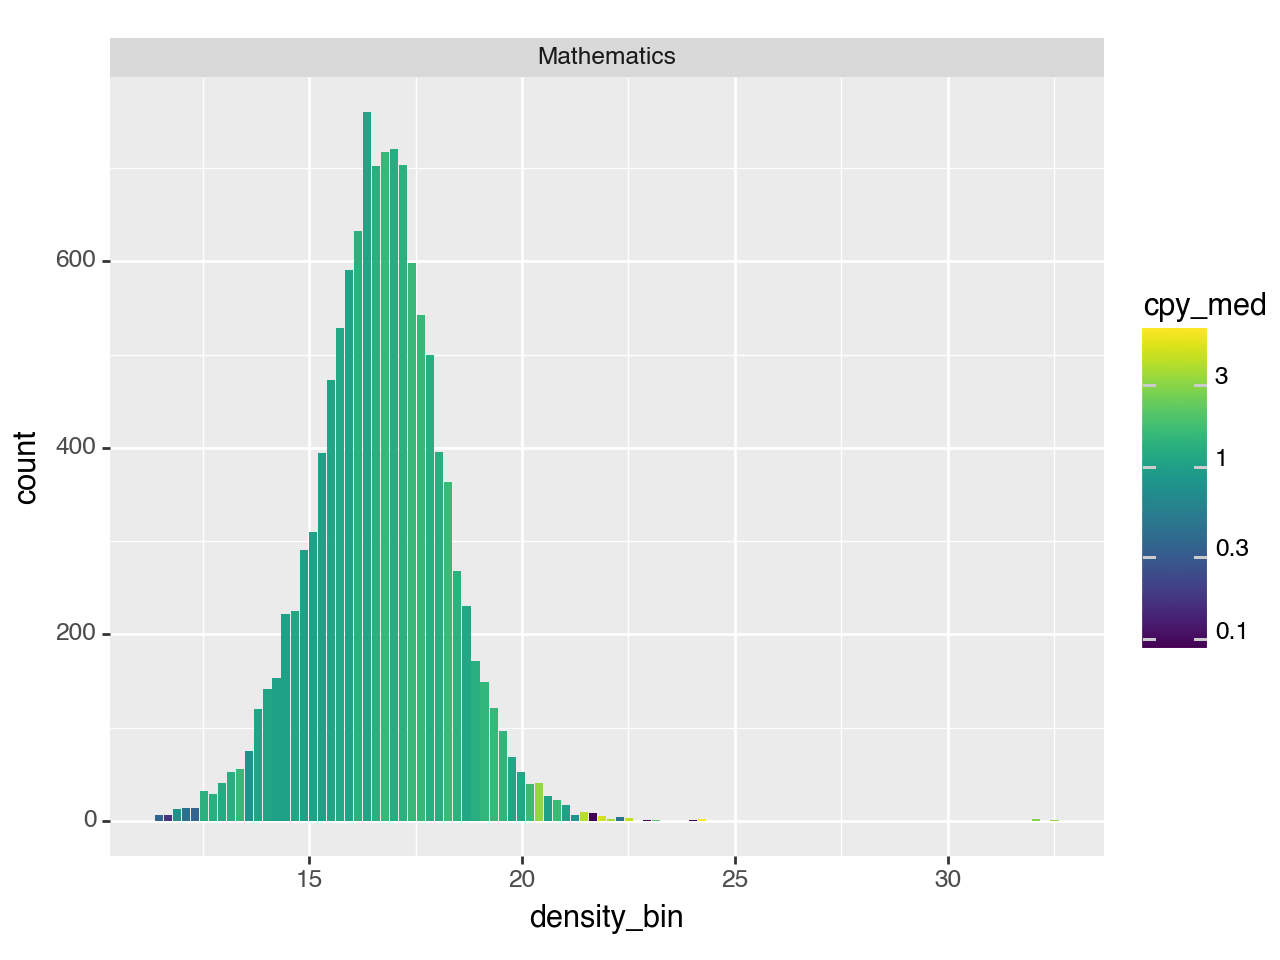

In [214]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            # fill="log_cpy variance",
            # fill="cpy_var",
            fill="cpy_med",
            # fill="log_cpy median",
            y="count",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
        + pn.scale_fill_continuous(trans = "log10")
    )


In [215]:
df_ent_all["log_cpy_variance"] = df_ent_all["log_cpy variance"]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/cit

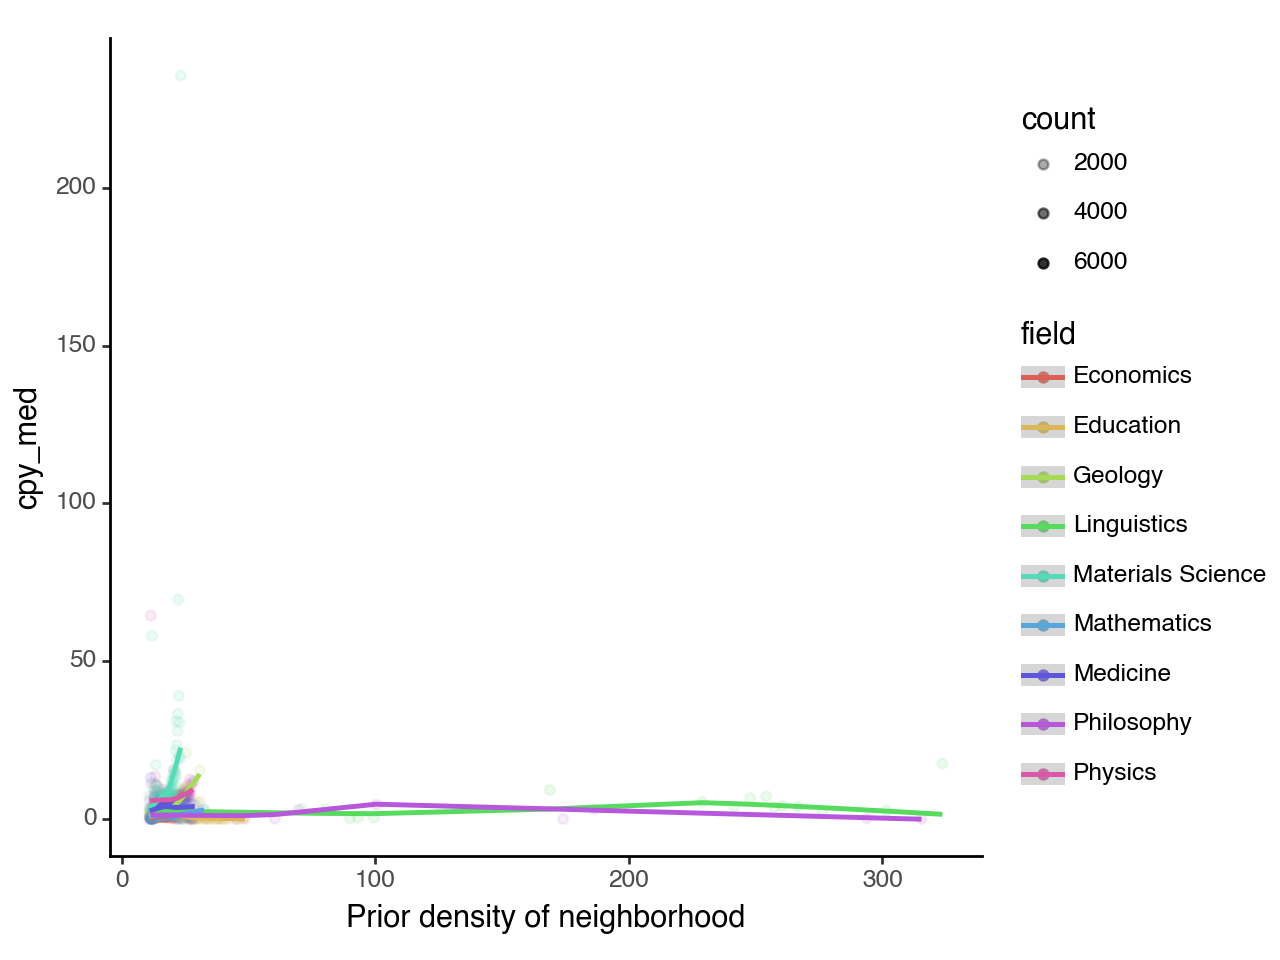

<Figure Size: (640 x 480)>

In [216]:
from scipy.stats import linregress

(
        pn.ggplot(
            df_ent_all[df_ent_all["count"] > 0], 
            pn.aes(
                x="density_bin",
                # y="log_cpy variance",
                y="cpy_med",
                color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                # size="freq",
                alpha="count",      
            )
        )
        + pn.geom_smooth(
            pn.aes(
                # color="field",
            ),
            # color="black",
        )
        # + pn.ylab("Variance in log citations per year")
        + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
)

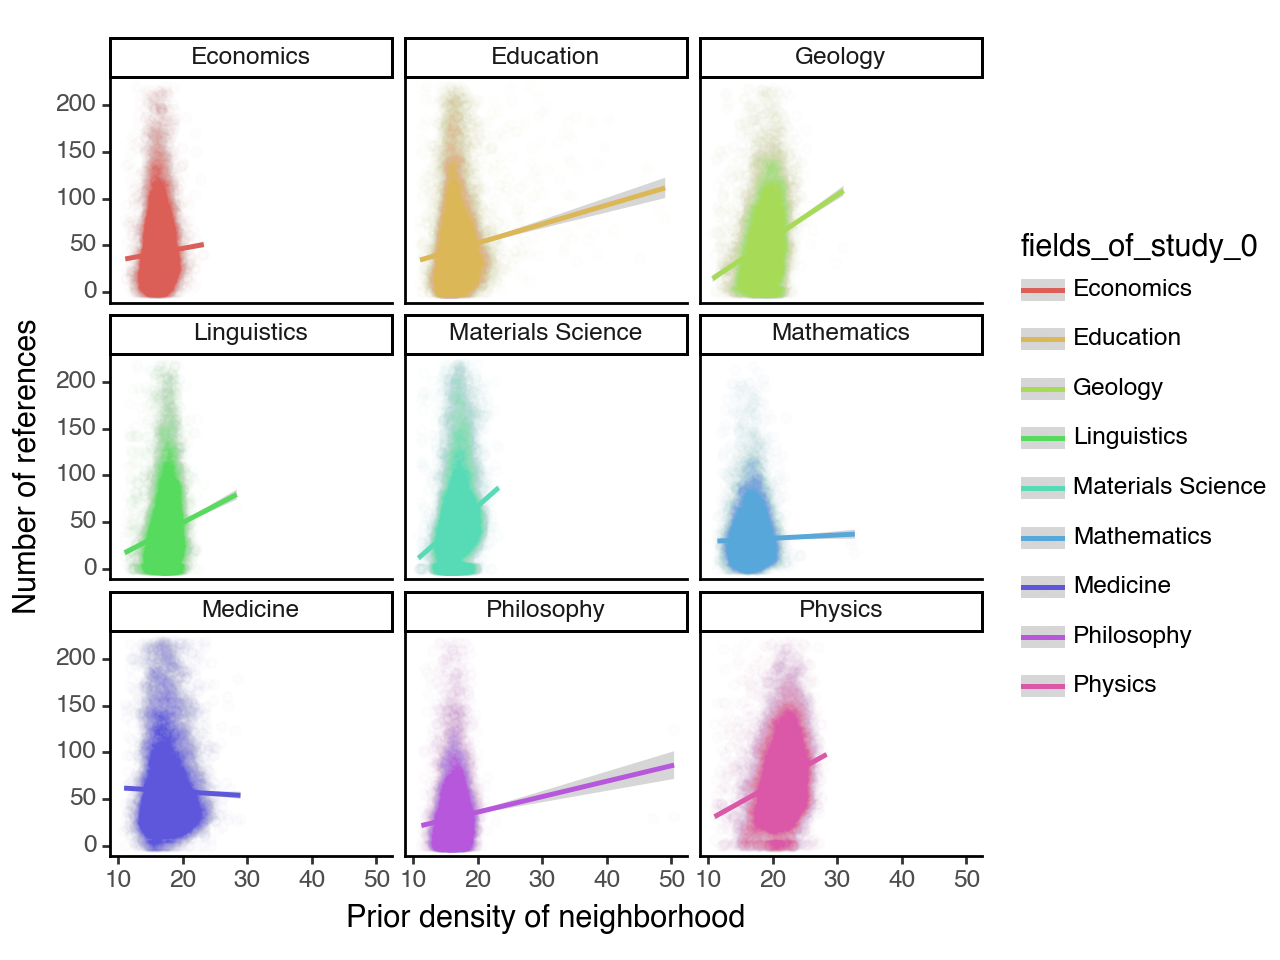

<Figure Size: (640 x 480)>

In [217]:
# Let's visualize reference length for all fields.

df_temp =  df[df["density"] < 60]
df_temp = df_temp[df_temp.references < (df_temp.references.mean())+2*df_temp.references.std()]

(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.xlab("Prior density of neighborhood")
    + pn.ylab("Number of references")
    + pn.theme_classic()
    # TODO: annotate each line with R^2, p-values
    # TODO: normalize each by the average number of references per field
)

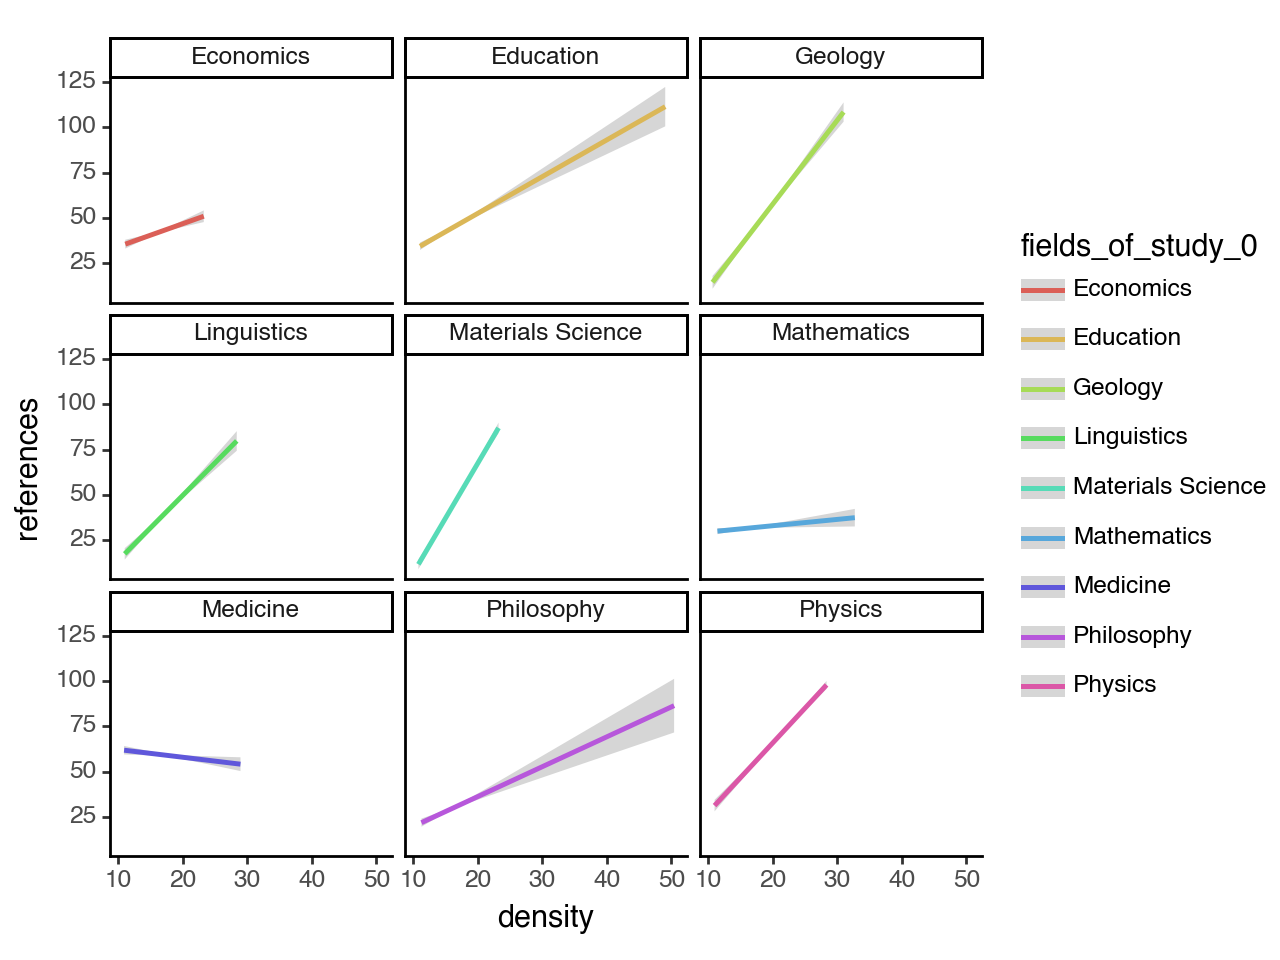

<Figure Size: (640 x 480)>

In [218]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            # x="references",
            # y="log_cpy",
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    # + pn.geom_point(alpha=0.01)
    # + pn.geom_hline( pn.aes(yintercept=df_temp.log_cpy.median().item()) )
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


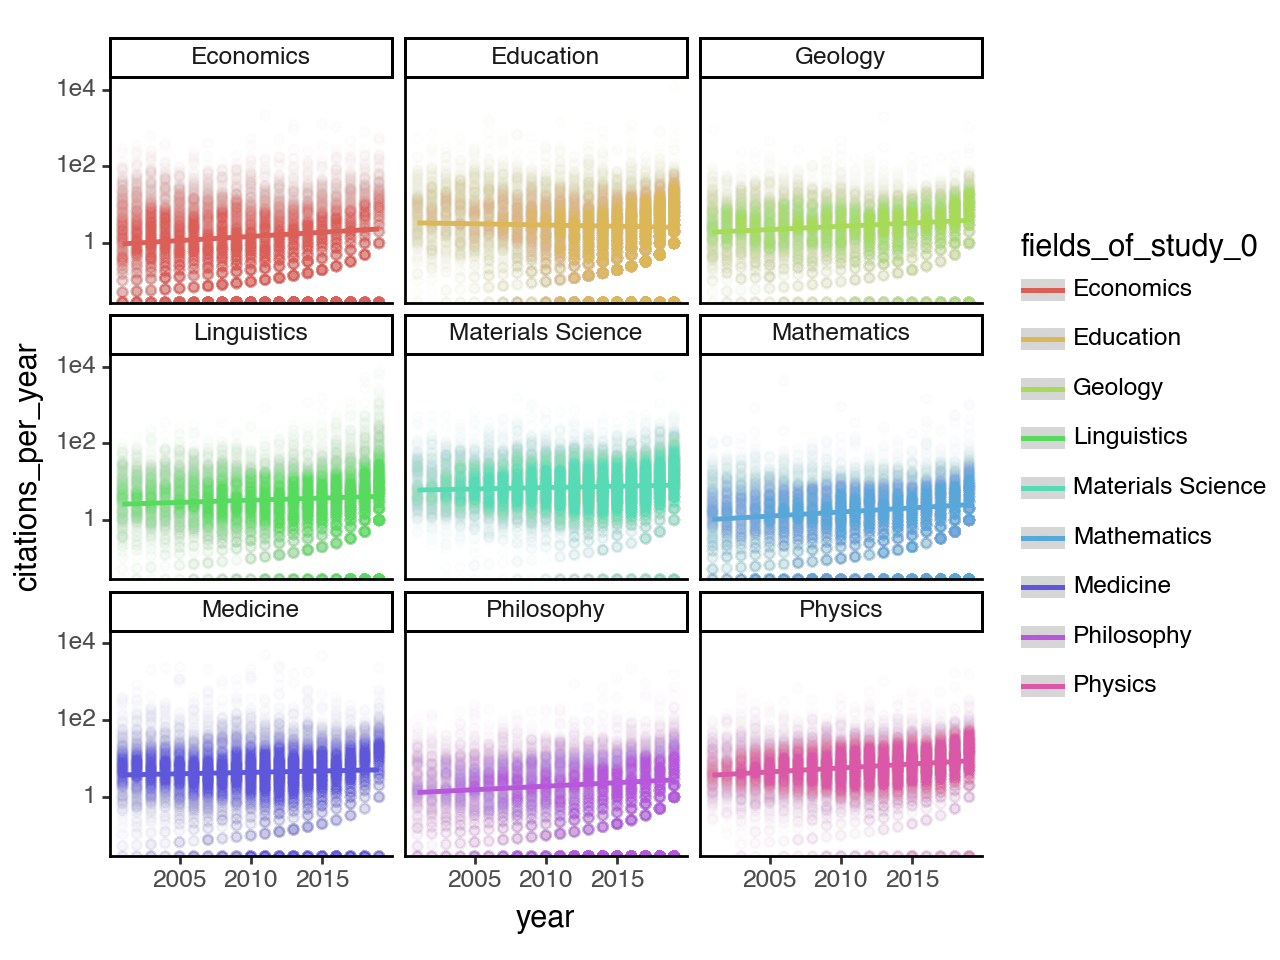

<Figure Size: (640 x 480)>

In [219]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="year",
            y="citations_per_year",
            color="fields_of_study_0",
        )
    )
    + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

In [220]:
# try in R, maybe its prettier.
# df_ent_all.to_csv(f"{vectorizer}_cpy_variance_data.csv", index=False)

In [221]:
df.year.value_counts()

year
2019    7528
2018    7511
2017    7468
2016    7314
2014    7205
2013    7025
2015    6982
2012    6791
2011    6210
2010    5833
2009    5473
2008    5212
2007    4871
2006    4435
2005    4264
2004    3880
2003    3586
2002    3197
2001    2859
Name: count, dtype: int64

#### Zach style main trend plot from ads paper

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

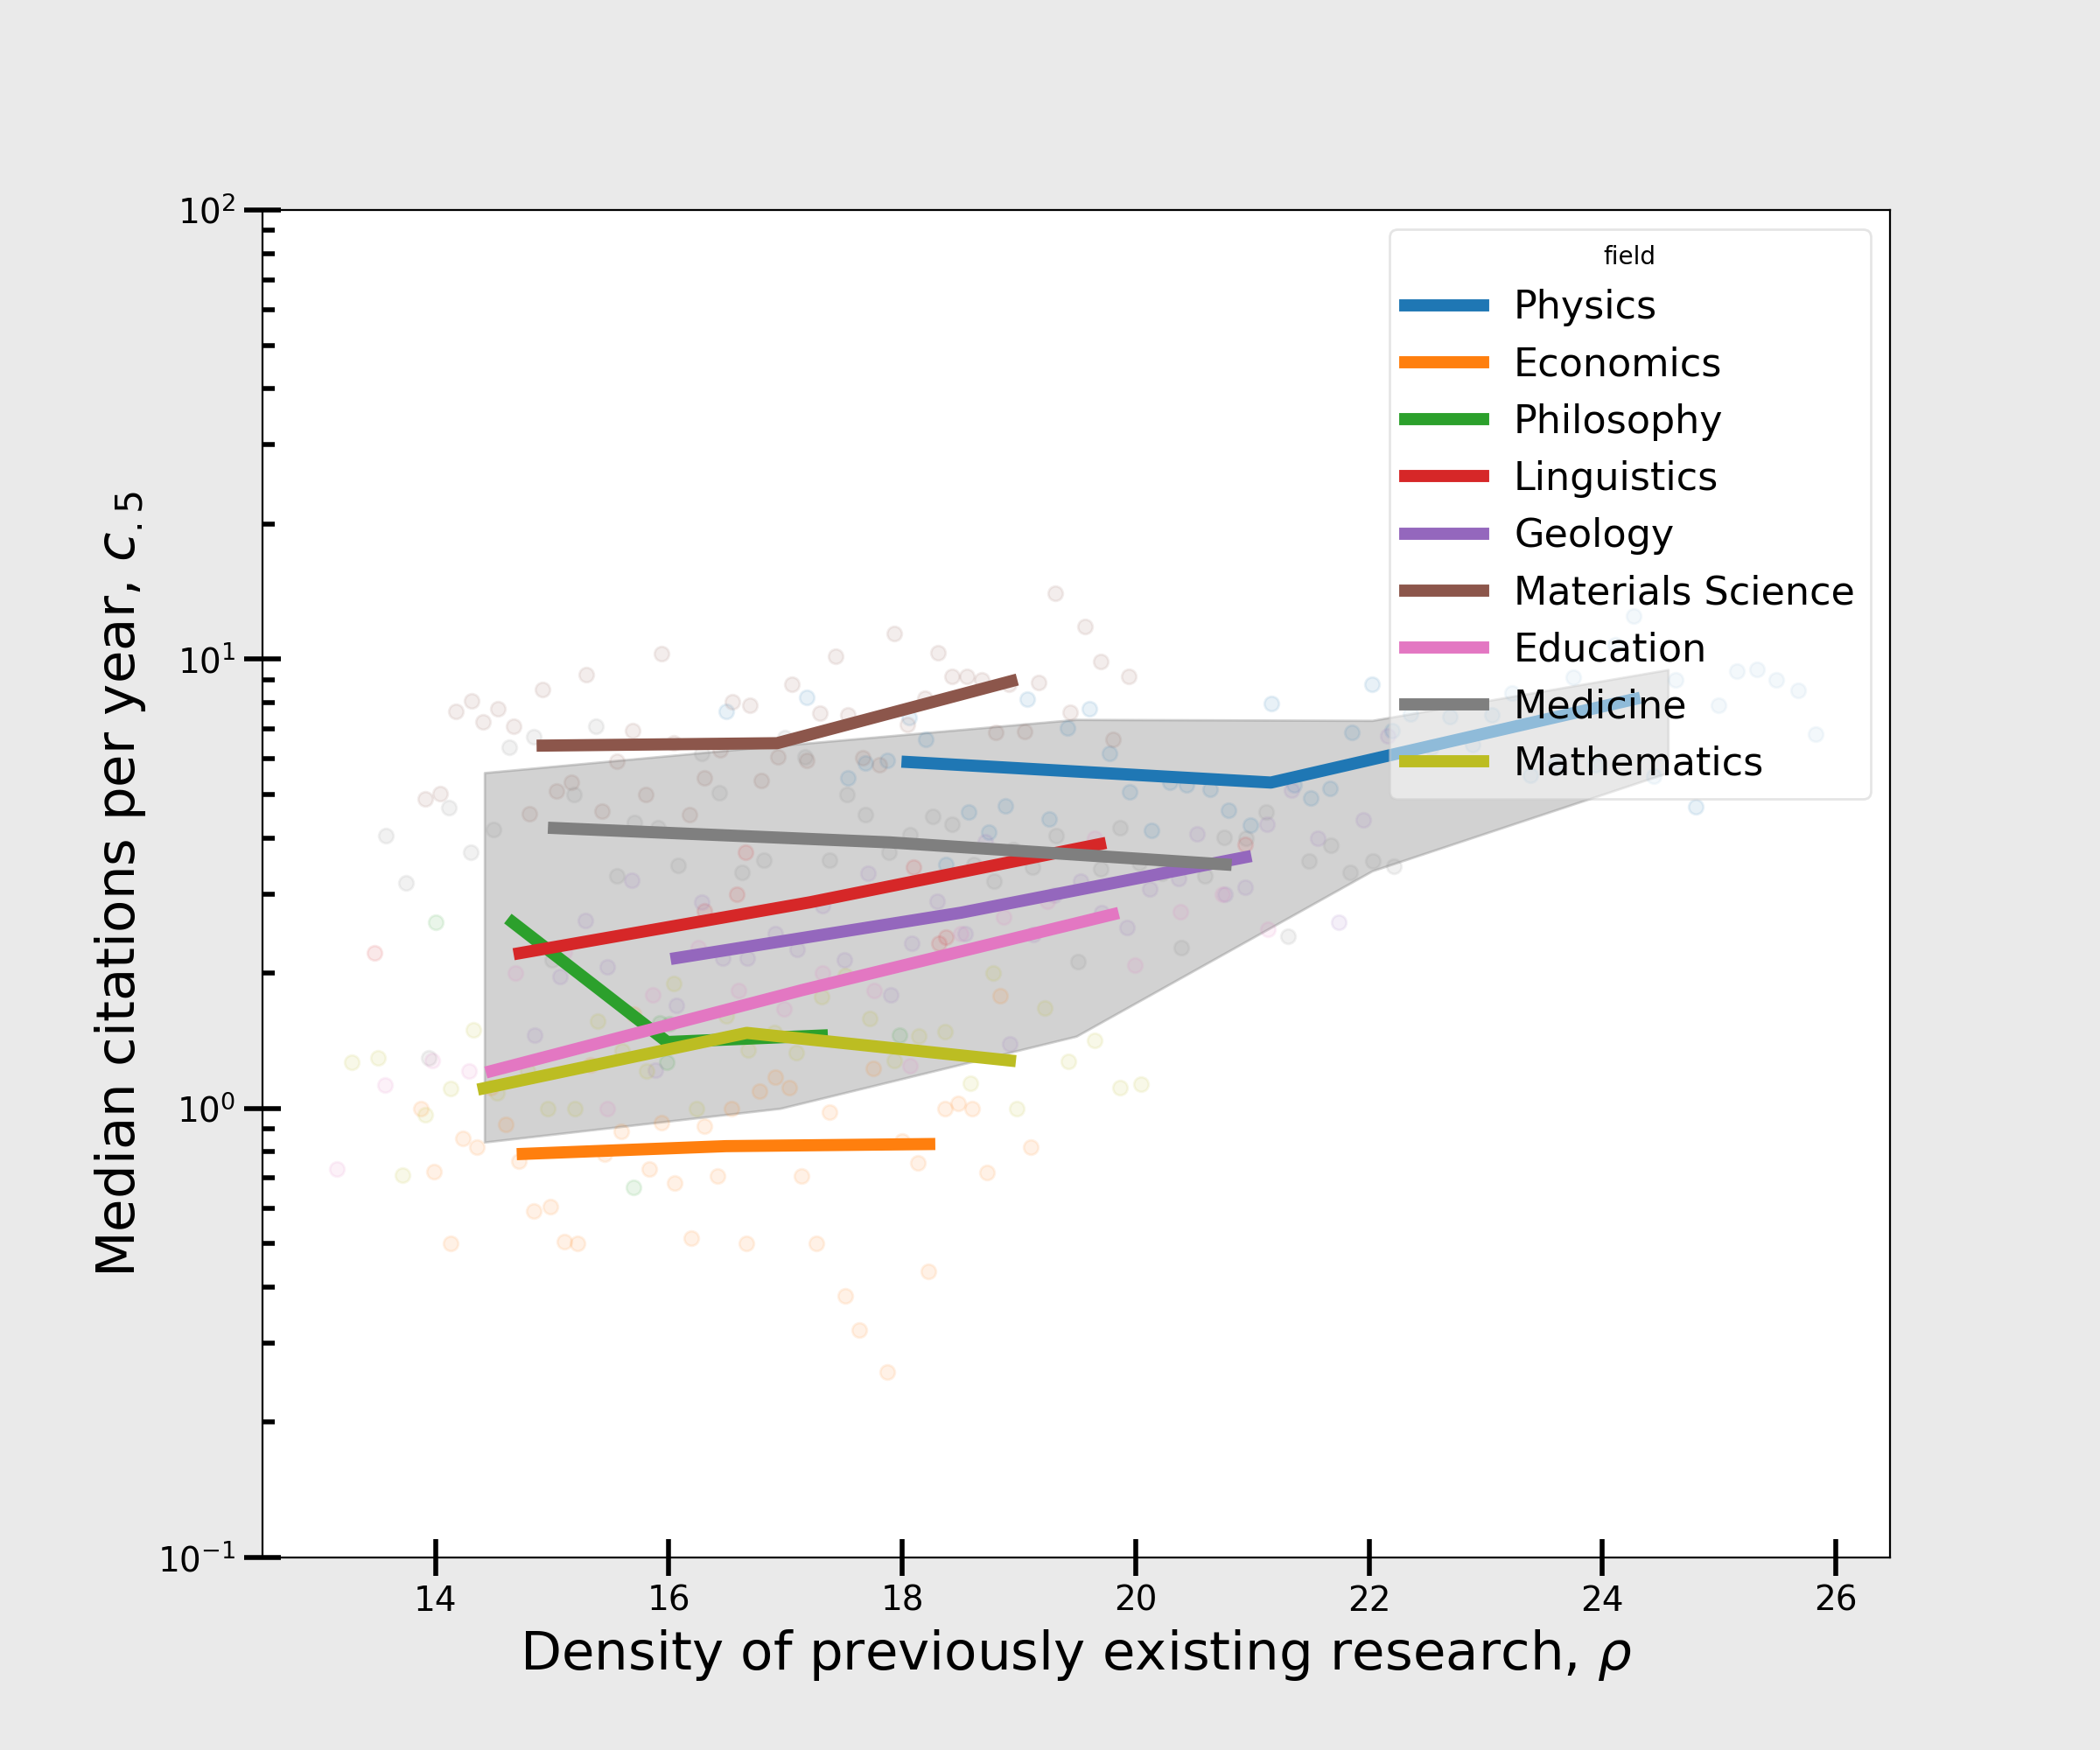

In [222]:
import matplotlib
import matplotlib.pyplot as plt
import scipy


# df_mpl = pd.read_csv("dmb_vs_log_cpy_var.csv")
df_mpl = pd.concat(
    [get_df_var(df, field, n_bin=50)
    for field in df["fields_of_study_0"].unique()],
)


facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()

e_n = df_mpl["density_med_bin"]

mult = 1.

cpy_v = df_mpl["cpy_med_bin"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    6,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# add fields
fields = df_mpl.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_mpl[df_mpl["field"] == field]

    e_n = df_field["density_med_bin"]

    cpy_v = df_field["cpy_med_bin"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor,
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_yscale( 'log' )
ax.set_ylim(0.1, 100)

# Axis labels
# ax.set_ylabel( r'Variance in citations per year, $\sigma^2$', fontsize=22 )
ax.set_ylabel( r'Median citations per year, $c_{.5}$', fontsize=22 )
ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Because the plotting data involves sampling, there are a lot of spurious researcher degrees of freedom in selecting which trends to show! Because some of these fields are only slighltly decreasing in variance, esp economics, and linguistics, it's important to reflect that, but it's also important to not just sample the best looking plot for our story. Need some more principled way of plotting the relationship.

In [223]:
df_ent_new = pd.concat(
    [get_df_ent(df, field, num_bins=1000)
    for field in df_all["fields_of_study_0"].unique()],
)

df_ent_new = df_ent_new[df_ent_new["count"] > 10]
df_ent_new["log_cpy_var"] = df_ent_new["log_cpy variance"]
df_ent_new.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_37982/3592053724.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/numpy/lib/nanfunc

density_bin      freq  count  log_cpy entropy  log_cpy variance  \
382       17.637  0.000972     11       308.825538          0.243372   
387       17.724  0.001061     12              NaN          0.323799   
396       17.880  0.001061     12       338.850793          0.189980   
399       17.932  0.000972     11       354.042060          0.311157   
407       18.071  0.001326     15              NaN          0.148070   

     log_cpy median      cpy_var    cpy_med   cpy_mean  ref_med       ref_var  \
382        0.778151    79.016199   6.000000   8.865280     49.0    733.603306   
387        0.753328    80.115768   5.055556   9.272300     46.5   1065.576389   
396        0.540482    82.128921   3.472222   7.168708     39.5   1618.076389   
399        1.075879  2088.495921  11.909091  36.246133     82.0  25999.471074   
407        0.902996   194.638915   7.833333  12.491795     40.0    638.915556   

     year_med    field  log_cpy_var  
382    2009.0  Physics     0.243372  
387    2013.5  Physics     0.323799  
396    2006.0  Physics     0.189980  
399    2013.0  Physics     0.311157  
407    2008.0  Physics     0.148070

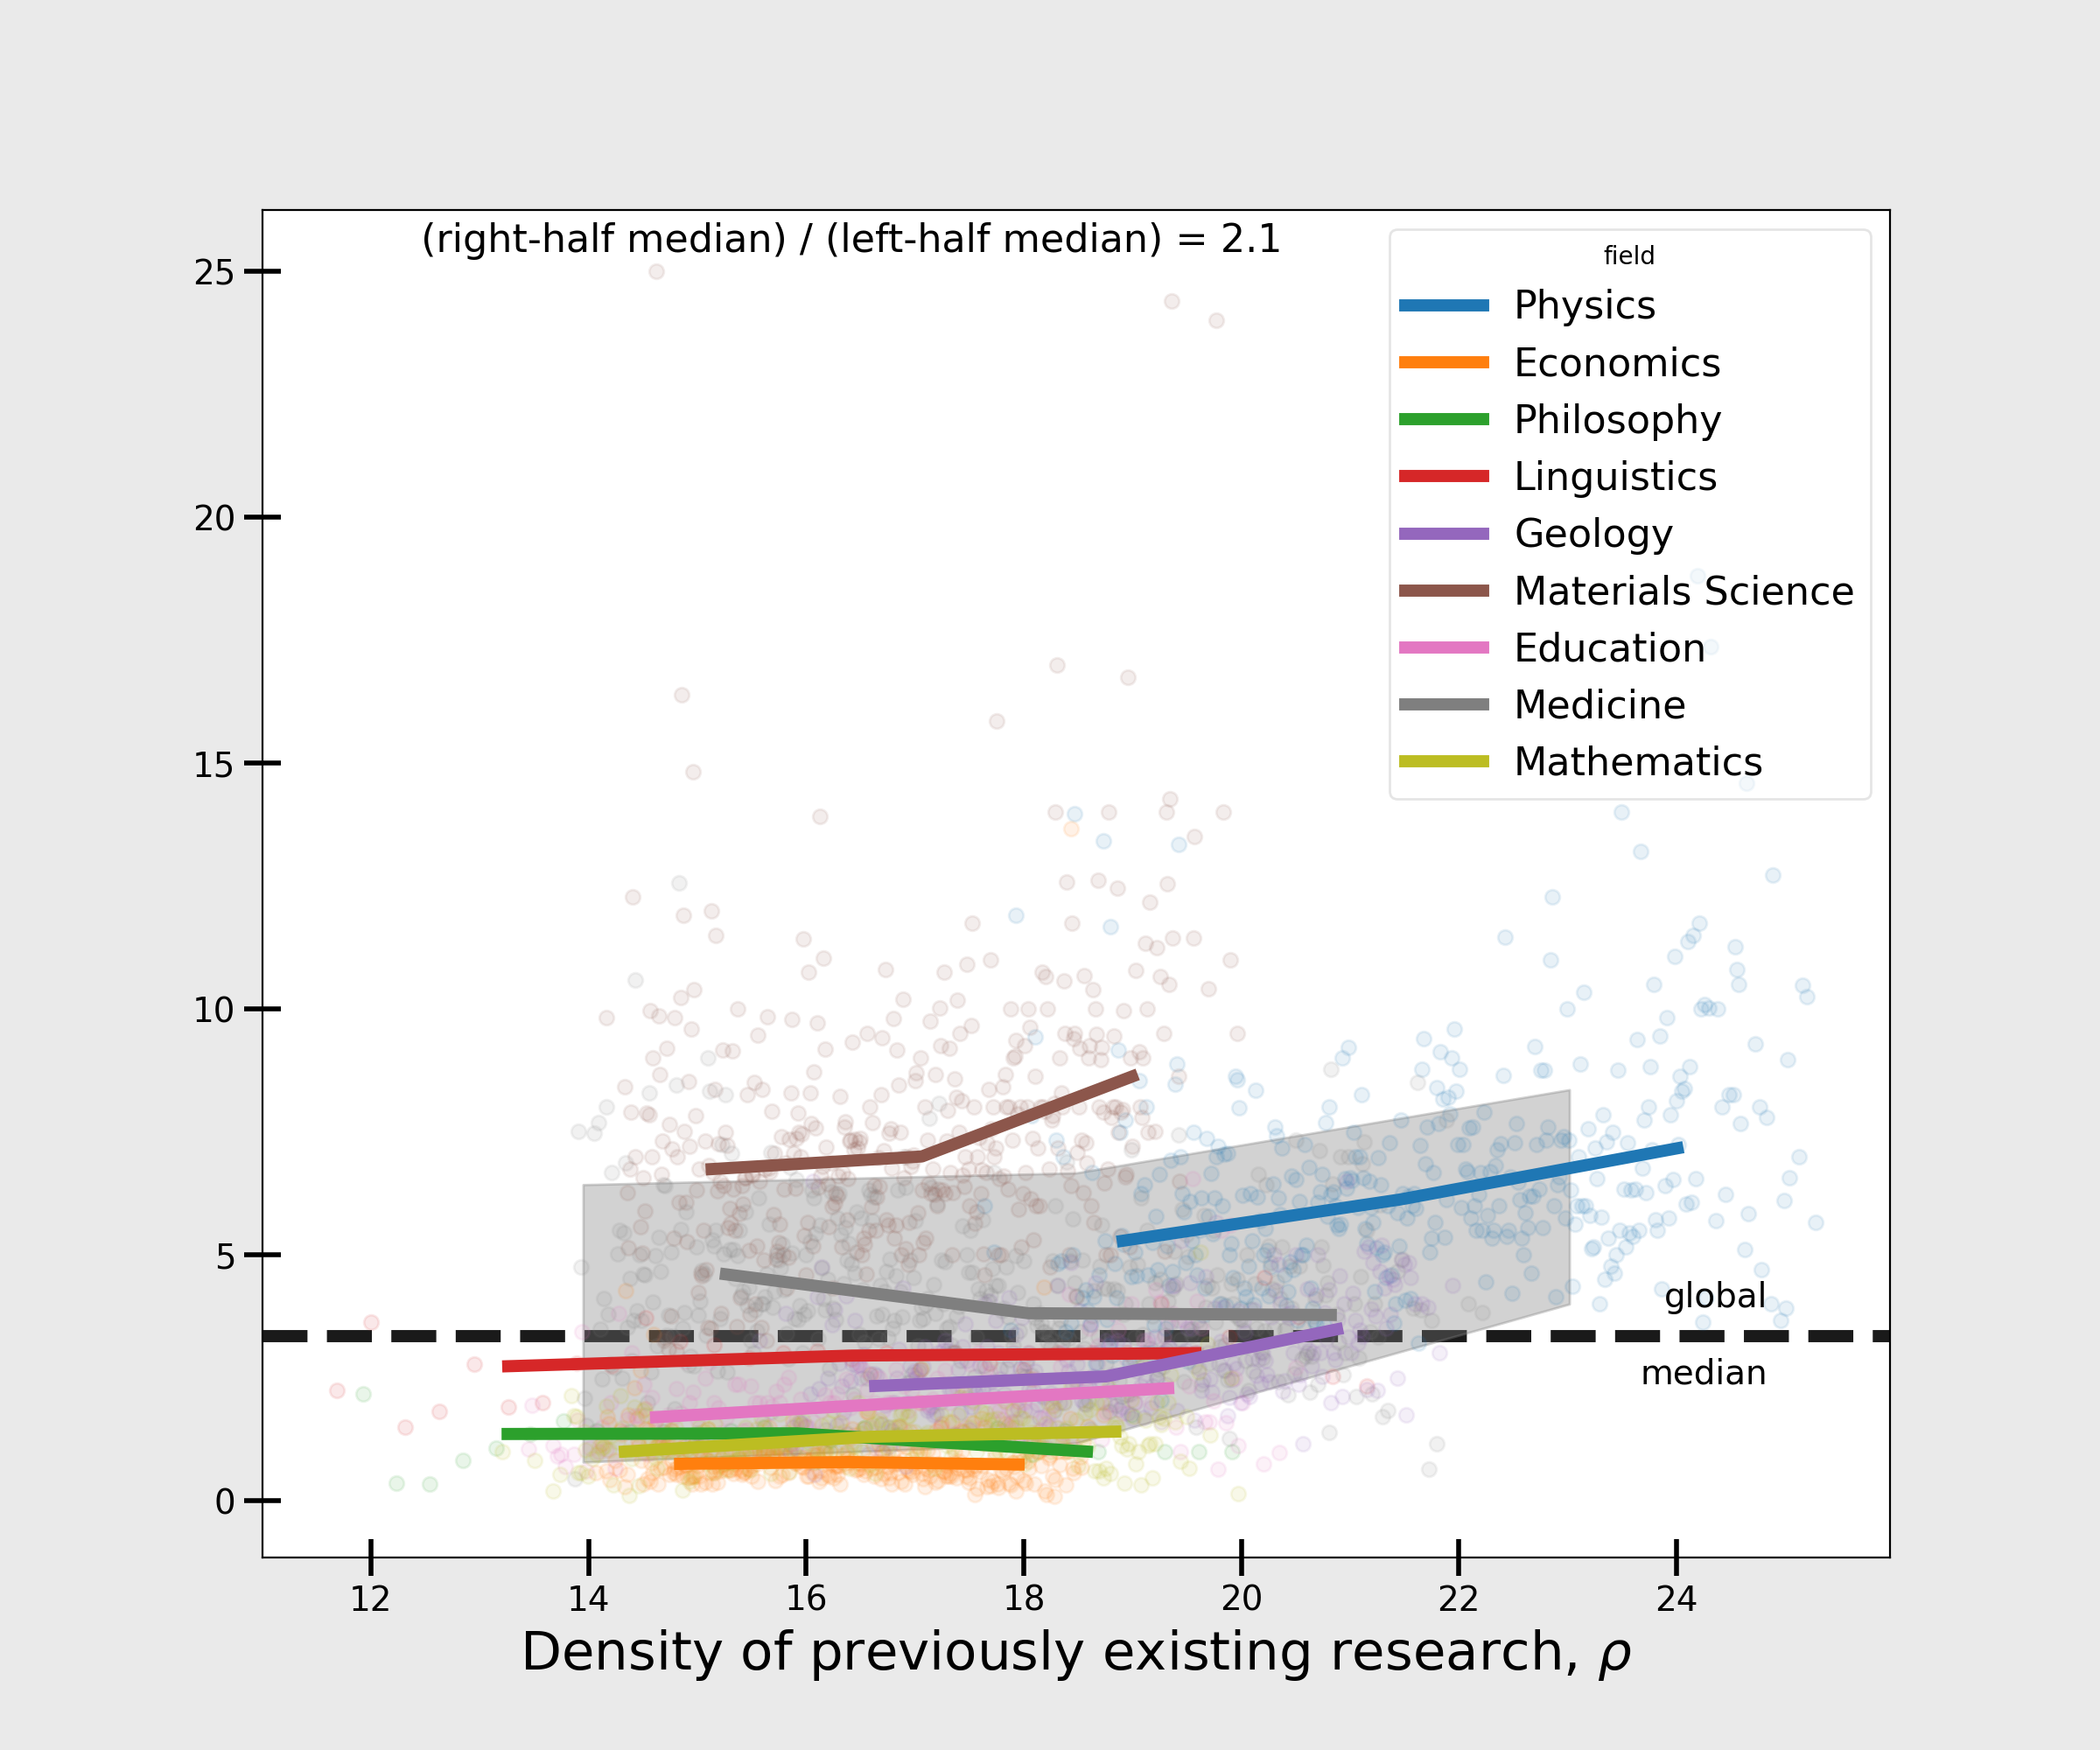

In [224]:
facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()


e_n = df_ent_new["density_bin"]

mult = 1.

cpy_v = df_ent_new["cpy_med"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    4,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# Global median number of citations (baseline)
global_median = np.nanpercentile( cpy_v, 50. )
ax.axhline(
    global_median,
    color = '0.1',
    linestyle = '--',
    linewidth = 5,
    zorder = -100,
)
ax.annotate(
    text = 'global\n\nmedian',
    xy = (bin_edges[-1], global_median),
    xycoords = 'data',
    xytext = (-20, 0),
    textcoords = 'offset points',
    va = 'center',
    ha = 'right',
    fontsize = 14,
)

# Summary statistics  
top_half = e_n > np.nanmean( e_n )
cpy_top = cpy_v[top_half]
cpy_bottom = cpy_v[np.invert(top_half)]
cpy_mult = np.nanmedian( cpy_top ) / np.nanmedian( cpy_bottom )
frac_below = ( cpy_top < global_median ).sum() / cpy_top.size
s = (
    r' (right-half median) / (left-half median) =' +
    ' {:.2g}'.format( cpy_mult ) #+
)
values = ax.annotate(
    text = s,
    xy = (1, 1),
    xycoords = 'axes fraction',
    xytext = (-250, -5),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 16,
)

# add fields
fields = df_ent_new.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_ent_new[df_ent_new["field"] == field]

    e_n = df_field["density_bin"]

    cpy_v = df_field["cpy_med"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)

# ax.set_yscale( 'log' )
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(False)

# ax.set_ylim(0,10)
# ax.set_ylim(0.1,0.8)
# ax.set_xlim(25,50)
# ax.set_ylim(0.1,100)

# Axis labels
# ax.set_ylabel( r'Variance in citations per year, $\sigma_{c}^2$', fontsize=22 )
# ax.set_ylabel( r'Median citations per year, $c_{cpy}$', fontsize=22 )

ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Can we make double figure like og ads paper?

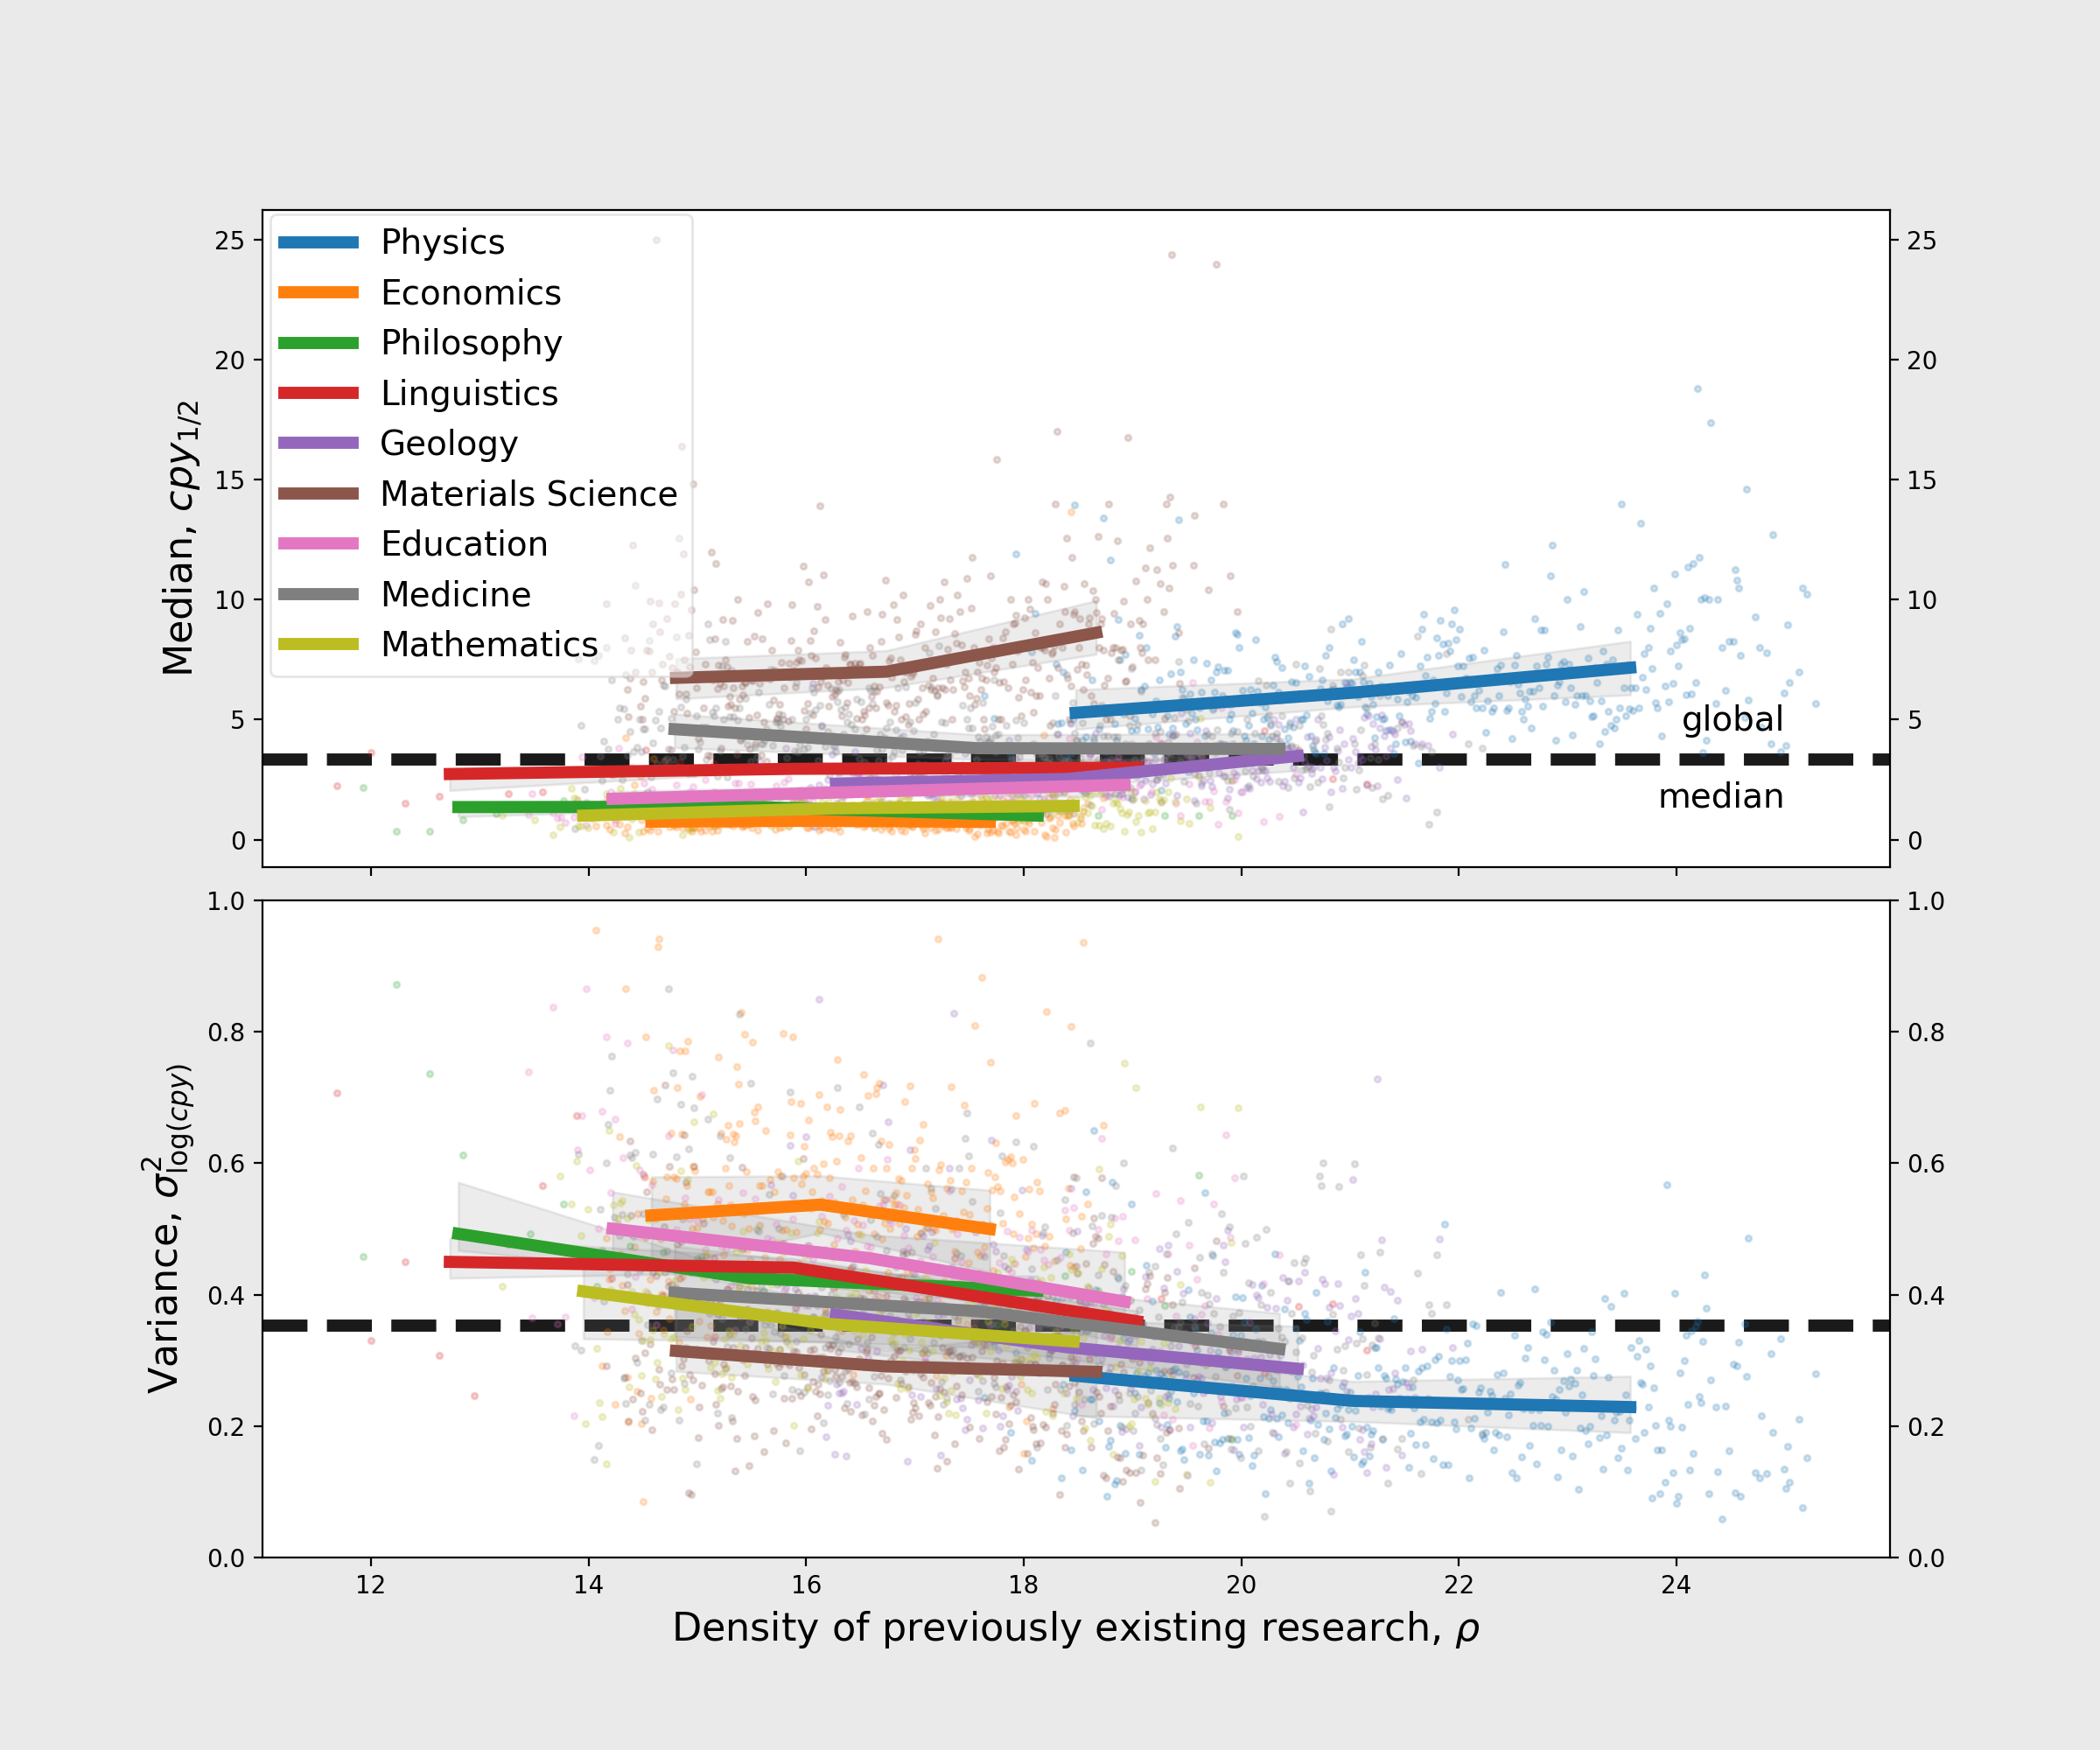

In [242]:
import warnings
import matplotlib.gridspec as gridspec


df_plot = df_ent_new

# df_plot = pd.concat(
#     [get_df_var(df, field, n_bin=20)
#     for field in df["fields_of_study_0"].unique()],
# )


rows = ["median", "variance"]
n_rows = 2

fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )
# ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "density_bin"
# x_variable = "density_med_bin"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "log_cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    # GLobal

    bin_edges = np.linspace(
        x_observations.min(),
        y_observations.max(),
        4,
    )

    xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    # median, bin_edges, _ = scipy.stats.binned_statistic( x_observations, y_observations, 'median', bins=bin_edges )
    # ax.plot(
    #     mult * xs,
    #     median,
    #     linewidth = 10,
    #     color = "black",
    # )    


    # Global median number of citations (baseline)
    global_median = np.nanpercentile( y_observations, 50. )
    ax.axhline(
        global_median,
        color = '0.1',
        linestyle = '--',
        linewidth = 5,
        zorder = -100,
    )
    ax.annotate(
        text = 'global\n\nmedian',
        xy = (bin_edges[-1], global_median),
        xycoords = 'data',
        xytext = (0, 0),
        textcoords = 'offset points',
        va = 'center',
        ha = 'right',
        fontsize = 14,
    )    


    #######################################
    # Fields
    #######################################      

    fields = df_ent_new.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_field = df_plot[df_plot["field"] == field]

        x_observations_field = df_field[x_variable]
        y_observations_field = df_field[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            4,
        )

        xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 68 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 32 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            mult * xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            mult * x_observations_field,
            y_observations_field,
            alpha = 0.2,
            s=6,
            # label=field,
        )    

        ax.plot(
            mult * xs,
            median,
            linewidth = 5,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)                
        # ax.set_xlim(22,47)        
        # ax.set_ylim(0,11)
        # ax.set_xlim(12,25) 
        # ax.set_ylim(0,15)       
        ax.set_ylabel( r'Median, ${cpy}_{1/2}$', fontsize=16 )

        # Customize ticks
        # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
        # ax.tick_params( which='minor', direction='in', size=0, width=2, )


    if row == "variance":
        # ax.set_yscale( 'log' )
        # ax.set_ylim(10,1e4)
        # ax.set_xlim(22,47)
        ax.set_ylim(0, 1,)
        ax.set_xlim(12,25)
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)        

        ax.set_ylabel( r'Variance, $\sigma_{\log(cpy)}^2$', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.62, axbox.y0 + 0.2),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=16 )

# plt.tight_layout()

plt.show()


In [226]:
df_plot.to_csv(f"{vectorizer}_main_data.csv", index=False)

#### References

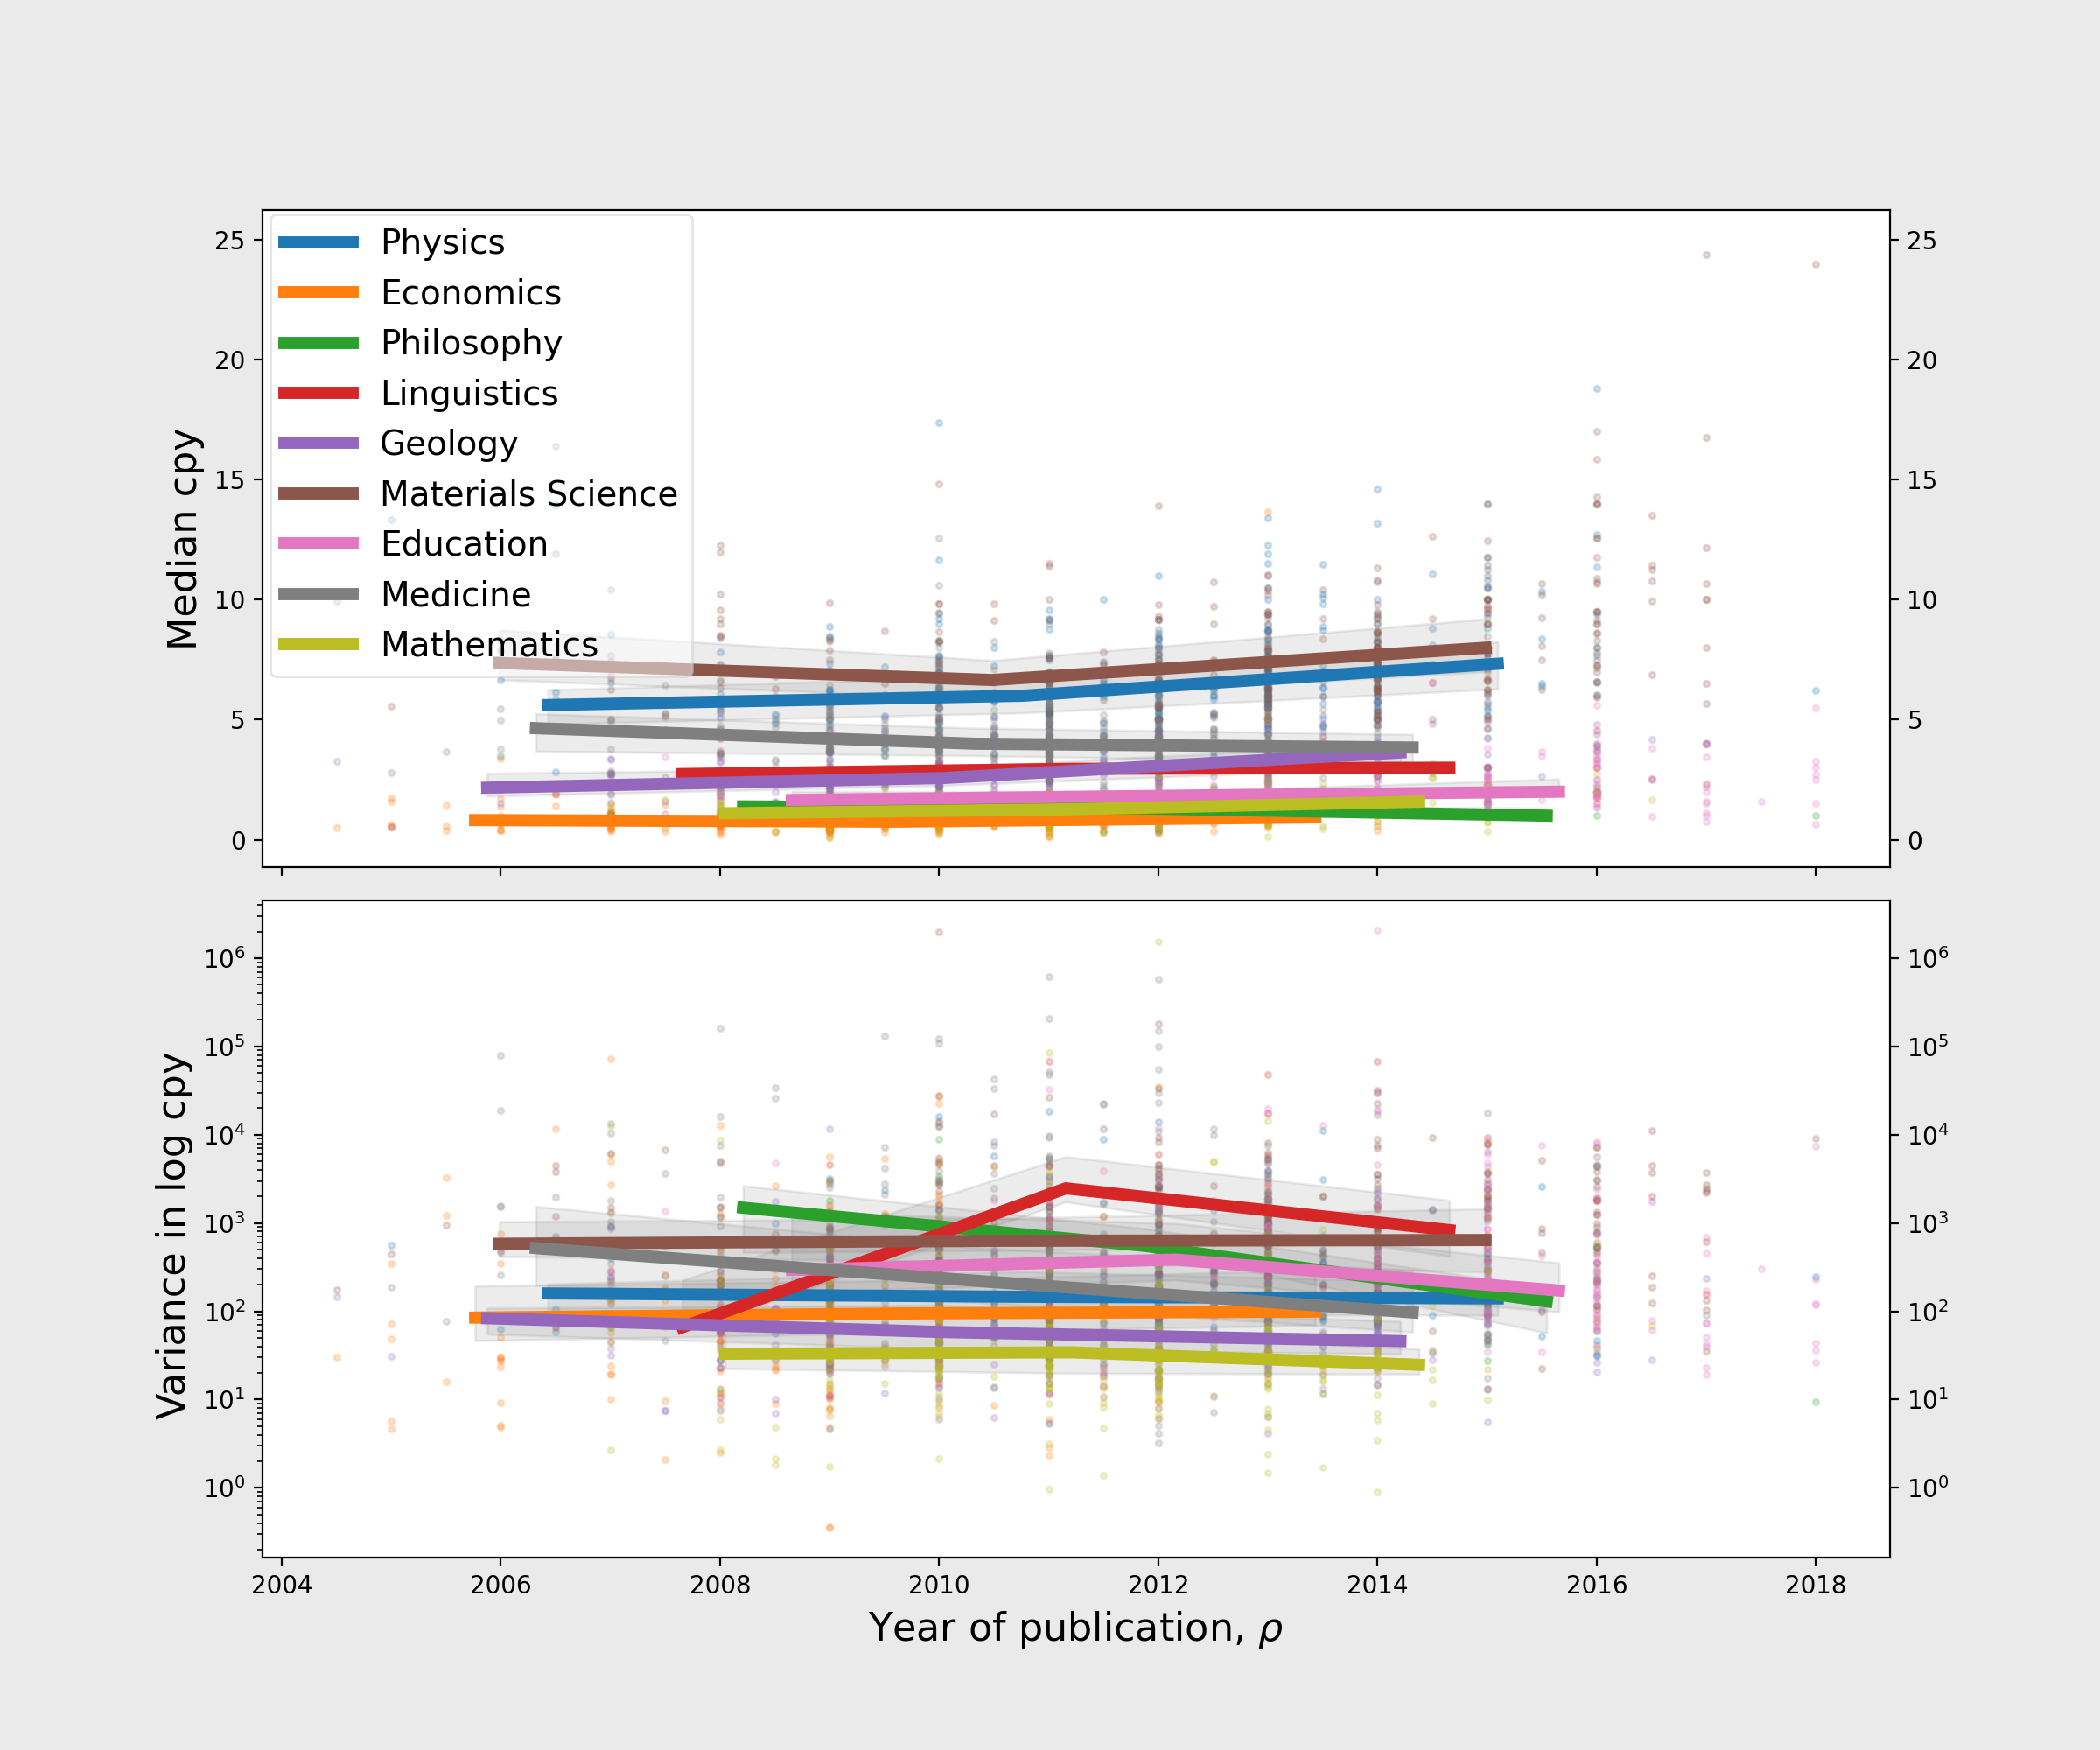

In [227]:
import warnings
import matplotlib.gridspec as gridspec


df_plot = df_ent_new

# df_plot = pd.concat(
#     [get_df_var(df, field, n_bin=20)
#     for field in df["fields_of_study_0"].unique()],
# )


rows = ["median", "variance"]
n_rows = 2

fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )
# ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "year_med"
# x_variable = "density_bin"
# x_variable = "density_med_bin"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    #######################################
    # Fields
    #######################################      

    fields = df_ent_new.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_field = df_plot[df_plot["field"] == field]

        x_observations_field = df_field[x_variable]
        y_observations_field = df_field[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            4,
        )

        xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 68 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 32 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            mult * xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            mult * x_observations_field,
            y_observations_field,
            alpha = 0.2,
            s=6,
            # label=field,
        )    

        ax.plot(
            mult * xs,
            median,
            linewidth = 5,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)                
        # ax.set_xlim(22,47)        
        # ax.set_ylim(0,11)
        # ax.set_ylabel( 'Median references', fontsize=16 )
        ax.set_ylabel( 'Median cpy', fontsize=16 )        

        # Customize ticks
        # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
        # ax.tick_params( which='minor', direction='in', size=0, width=2, )


    if row == "variance":
        ax.set_yscale( 'log' )
        # ax.set_ylim(10,1e4)
        # ax.set_xlim(22,47)
        # ax.set_ylim(0,1.,)
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)        

        # ax.set_ylabel( 'Variance in # references ', fontsize=16 )
        ax.set_ylabel( 'Variance in log cpy ', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.62, axbox.y0 + 0.2),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_xlabel( r'Year of publication, $\rho$', fontsize=16 )

# plt.tight_layout()

plt.show()
